# ML in Cybersecurity: Project I

## Team
  * **Team name**:  *The Overestimators*
  * **Members**:  *Anilkumar Erappanakoppal Swamy (2571210) (s8anerap@stud.uni-saarland.de) , Ayan Majumdar (2571656) (s8aymaju@stud.uni-saarland.de), Sravani Pasam (2576612) (s8srpasa@stud.uni-saarland.de)*
  * **Tutor**: *Kathrine Grosse (kathrin.grosse@cispa.saarland)*


## About this Project
In this project, you'll implement a digit classifier, based on the popular [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. The dataset is based on a seminal [paper](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), which immensely popularized (convolutional) neural networks. This is a great starting point for ML research and this dataset/model has been a stepping stone numerous other tasks such as [GANs](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf), [Adversarial Perturbations](https://arxiv.org/abs/1412.6572) and so many more!

This dataset consists of data $\mathcal{D} = \{x_i, y_i\}_{i=1}^N$, where $x_i$ is a 28x28 pixel grayscale image and $y_i$ is a scalar represeting digits between 0-9. The notebook will guide you to load this data, implement classifiers $\hat{y_i} = f_w(x_i)$  and analyze results. By doing so, you'll have a ML model that works on real data!

To put things into context, have a look at Slide 24 in the [second](https://cms.cispa.saarland/mlcysec/dl/2/2018-10-24_ML_overview.pdf) lecture. Within this framework, the following blocks of this project are fixed:
  * *Real-world problem*: Digit classification
  * *Performance metric*: Mean accuracy i.e., $ \frac{1}{N} \sum_{i=1}^N \mathbb{1}[\hat{y_i} = y_i]$, where $\mathbb{1}[\hat{y_i} = y_i]$ is 1 if your model predicted the right digit for the $i$-th digit and 0 otherwise.
  * *Data*: The MNIST dataset

You'll make the the following design-choices:
 * *Choice of Model*: A model family (Non-parametric methods, Linear classifiers, Neural Networks, etc.)
 * *ML Model*: Specific model (e.g., SVM with a polynomial kernel)
 * *Loss/Risk*
 * *Optimization*

 
 ## Versions
  * v1.1: Added Code of Honor
  * v1.0: Initial notebook
  
  ---

In [3]:
import time 
 
import numpy as np 
import matplotlib.pyplot as plt 

import json 
import time 
import pickle 
import sys 
import csv 
import os 
import os.path as osp 
import shutil 

import pandas as pd

from IPython.display import display, HTML
 
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots 
plt.rcParams['image.interpolation'] = 'nearest' 
plt.rcParams['image.cmap'] = 'gray' 
 
# for auto-reloading external modules 
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Load other libraries here.
# Keep it minimal! We should be easily able to reproduce your code.

# In case you want to use neural networks, we only support sklearn and keras (With a tensorflow backend).

import inspect
from random import randint
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import sklearn.model_selection
from sklearn import preprocessing
import sklearn.metrics
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
import tensorflow as tf
from keras.datasets import mnist
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras import optimizers
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras import backend as K
K.set_image_dim_ordering('th')

Helpers

In case you choose to have some methods you plan to reuse during the notebook, define them here. This will avoid clutter and keep rest of the notebook succinct.

In [5]:
'''
grid_search_results: dict of results.
param_name1: Fix this value to param_name1_val.
param_name2: Will plot this param with respect to param_name2_space.
'''
def plot_validation_data(grid_search_results, param_name1, param_name2, param_name1_val, param_name2_space, plt_title="Plot_Title",plt_xlab="x_label",plt_ylab="y_label",color="darkblue",label="Label_Plot"):

    list_ids_param2 = []
    for i, x in enumerate(grid_search_results['params']):
        if x[param_name1] == param_name1_val:
            list_ids_param2.append(i)         

    test_scores_mean = grid_search_results['mean_test_score'][list_ids_param2]
    test_scores_std = grid_search_results['std_test_score'][list_ids_param2]

    plt.title(plt_title)
    plt.xlabel(plt_xlab)
    plt.ylabel(plt_ylab)
    
    plt.plot(param_name2_space, test_scores_mean,'o-', label=label,
             color=color)
    plt.fill_between(param_name2_space, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color=color)
    
    plt.legend(loc="best")
    plt.show()
    
def display_classification_results(y_test, y_pred,title="Heatmap"):
    print("Test accuracy: %.2f%%"%(sklearn.metrics.accuracy_score(y_test, y_pred)*100))
    print("Classification Report:\n",sklearn.metrics.classification_report(y_test, y_pred))

    conf_mat = sklearn.metrics.confusion_matrix(y_test,y_pred)
    print("Confidence Matrix:\n",conf_mat)
    ax = sns.heatmap(conf_mat);
    ax.set(title=title, xlabel="Digits", ylabel="Digits");
    
def LoadData_PreProcess():
    # load the MNIST dataset using keras high-level functions
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    # plot 6 images as gray scale from the dataset  
    plt.subplot(231)
    plt.imshow(X_train[np.random.randint(low=0, high = 50)], cmap=plt.get_cmap('gray'))
    plt.subplot(232)
    plt.imshow(X_train[np.random.randint(low=0, high = 50)], cmap=plt.get_cmap('gray'))
    plt.subplot(233)
    plt.imshow(X_train[np.random.randint(low=0, high = 50)], cmap=plt.get_cmap('gray'))
    plt.subplot(234)
    plt.imshow(X_train[np.random.randint(low=0, high = 50)], cmap=plt.get_cmap('gray'))
    plt.subplot(235)
    plt.imshow(X_train[np.random.randint(low=0, high = 50)], cmap=plt.get_cmap('gray'))
    plt.subplot(236)
    plt.imshow(X_train[np.random.randint(low=0, high = 50)], cmap=plt.get_cmap('gray'))
    # show the plot
    #   plt.show()


    # PrePorcessing
    # reshape to be [samples][pixels][width][height]
    X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
    X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')

    print(X_train.shape)

    # Normalize the pixel values from range 0-255 to 0-1
    X_train = X_train / 255
    X_test = X_test / 255


    # Output value ranges from 0-9, encode them into one hot vector
    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)

    return X_train, y_train, X_test, y_test

# 1. Loading and Visualizing data

In this section, you'll need to prepare the MNIST data for the experiments you'll be conducting for the remainder of the notebook.

## 1.1. Load Data

Here you'll load the MNIST data into memory. The end-goal is to two have the following variables:
  * `x_trainval`, `x_test`: of shape $N \times d_1 \times d_2 \dots$ (e.g., $N \times 784$. 784 since you could flatten each 28x28 pixel image into a single vector)
  * `y_trainval`, `y_test`: of shape $N \times K$ (K = 1 or 10 depending on how you plan to represent the ground-truth digit annotation)

You can either do this by:
  1. Downloading the MNIST dataset, unpacking and preparing it yourself to have fine-grained control
  1. Using high-level existing functions, such as the one provided by  [`keras.datasets`](https://keras.io/datasets/#mnist-database-of-handwritten-digits).
  
  
  In either case, it is important that you have disjoint trainval and test splits!

In [6]:
# fix random seed for reproducibility
seed = 21
np.random.seed(seed)

In [7]:
(x_trainval, y_trainval), (x_test, y_test) = mnist.load_data()

In [8]:
#
#
# ------- Your Code -------
#
#

print('x_trainval.shape = {},  y_trainval.shape = {}'.format(x_trainval.shape, y_trainval.shape))
print('x_test.shape = {},  y_test.shape = {}'.format(x_test.shape, y_test.shape))

#
# Feel free to have multiple variables in case your models are designed for different formats
# For instance, in case your model requires Nx28x28 inputs, declare x_trainval_3d, etc.

# Tip: Set this to a tiny number (such 0.05) to aid debugging
# After all, you do not want to train/evaluate on the entire dataset to find bugs
DEBUG_FRAC = 1.0
# Resample x_[], y_[]
x = np.concatenate((x_trainval, x_test))
#print(x.shape)
y = np.concatenate((y_trainval, y_test))
#print(y.shape)
sss = StratifiedShuffleSplit(n_splits=1, test_size=int(DEBUG_FRAC * x_test.shape[0]), train_size=int(DEBUG_FRAC * x_trainval.shape[0]), random_state=42)
idx = sss.split(x,y)
for train_idx, test_idx in idx:
    x_trainval, y_trainval = x[train_idx], y[train_idx]
    x_test, y_test = x[test_idx], y[test_idx]

print(x_trainval.shape, x_test.shape)

x_trainval.shape = (60000, 28, 28),  y_trainval.shape = (60000,)
x_test.shape = (10000, 28, 28),  y_test.shape = (10000,)
(60000, 28, 28) (10000, 28, 28)


In [9]:
# Scaling and Normalization

# Performing this for SVD
scaler = preprocessing.StandardScaler().fit(x_trainval.reshape(x_trainval.shape[0],-1))
x_trainval_scaled = scaler.transform(x_trainval.reshape(x_trainval.shape[0],-1))
x_test_scaled = scaler.transform(x_test.reshape(x_test.shape[0],-1))

# Do PCA
pca = PCA(0.95)
pca.fit(x_trainval_scaled)

x_trainval_red = pca.transform(x_trainval_scaled)
x_test_red = pca.transform(x_test_scaled)

print("Reduced:",x_trainval_red.shape)

# Performing this normalization for MLP as this gave better results.
x_trainval_nn = x_trainval.reshape(x_trainval.shape[0],-1)
x_test_nn = x_test.reshape(x_test.shape[0],-1)

# Make sure all values are between 0 and 1
x_trainval_nn = x_trainval_nn / 255.0
x_test_nn = x_test_nn / 255.0

print("Input dimension:", x_trainval_nn.shape)

D:\Anaconda3\envs\cysecml\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
D:\Anaconda3\envs\cysecml\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
D:\Anaconda3\envs\cysecml\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Reduced: (60000, 332)
Input dimension: (60000, 784)


In [82]:
# one hot encode outputs
# This format is necessary for Keras multiclass classification.

y_trainval_nn = np_utils.to_categorical(y_trainval)
num_classes = y_trainval_nn.shape[1]

print("Y_train Shape:",y_trainval_nn.shape)

print("Num Classes:", num_classes)
INPUT_DIMENSION = x_trainval_nn.shape[1]
print("Input Dimension:", INPUT_DIMENSION)

y_test_nn = np_utils.to_categorical(y_test)

Y_train Shape: (60000, 10)
Num Classes: 10
Input Dimension: 784


## 1.2. Visualize Data

To get the hang of your data you'll be training a digit classifier on, visualize it.

Examples of ways to visualize it:
  * Given a digit, display few randomly sampled images for this digit (the bare minimum)
  * Visualize as a grid (e.g., Slide 7, [Lecture 2](https://cms.cispa.saarland/mlcysec/dl/2/2018-10-24_ML_overview.pdf)) using a combination of `plt.imshow` and `plt.subplots`
  
It's up to you to decide how you want to do this. The end-goal is for you to potentially give a trailer of the dataset to someone who hasn't seen it before.

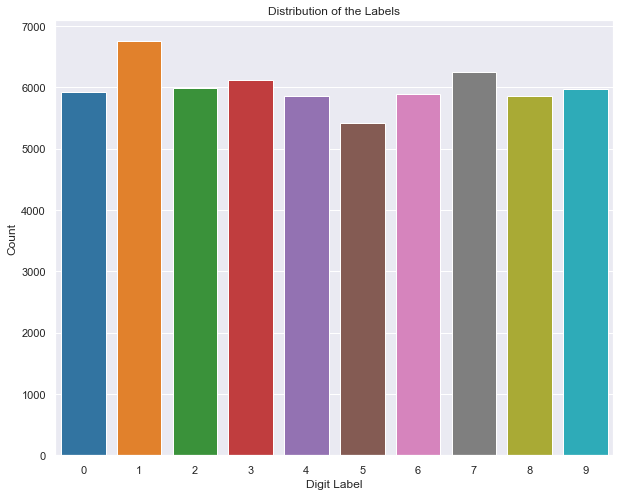

In [83]:
# Distribution of the data
ax = sns.countplot(y_trainval);
ax.set(title="Distribution of the Labels", xlabel="Digit Label", ylabel="Count");

(60000, 1, 28, 28)


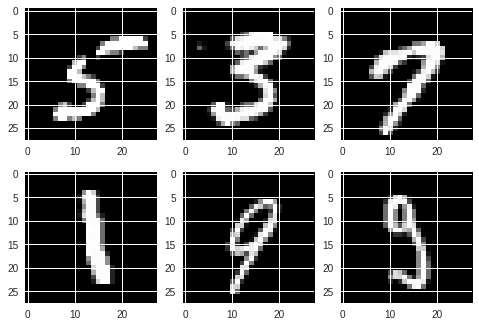

In [42]:
# Data utilities and training images display
X_train, y_train, X_test, y_test = LoadData_PreProcess()
n_classes = y_test.shape[1]

# 2. Digit classifiers

In this section, you'll begin developing models to perform digit classification.

Each model needs to be structured like so:
  1. Give a brief reason which model you are going to train and why you choose it
  1. Define hyper-parameters for model and optimization procedure
  1. Define your model
  1. Define optimization method and fit model to data
  1. Summarize your findings







## 2.1: Model [M1]: *SVM Classifier*

#### Short description : *We use an SVM Classifier with polynomial kernel to perform the multiclass classification task. We use scikit-learn grid search cross validation to perform hyperparameter selection of the hyperparameters C and gamma of SVM classifier (SVC). We feed the SVM Classifier a reduced dimensionality form of the original input after having the input properly centered and scaled and applying PCA with 95% variance of the data retained.*

### 2.1.1: Hyper-parameters

Define hyper-parameters for your method here

In [85]:
c_space = [0.05, 0.1, 0.5, 1]
gamma_space = [0.005, 0.01, 0.05, 0.1]
kernels = ["poly"]
param_space = {"C":c_space, "gamma":gamma_space, "kernel":kernels}
print(c_space, gamma_space)

print(x_trainval.shape)
#x_trainval_knn = x_trainval.reshape(x_trainval.shape[0],-1)
#x_trainval_svc = x_trainval.reshape(x_trainval.shape[0],-1)
x_trainval_svc = x_trainval_red
print(x_trainval_svc.shape)
y_trainval_svc = y_trainval
x_test_svc = x_test_red
y_test_svc = y_test

test_set = 'val'  #  or 'test'
# Decide all your hyperparameters based on validation performance
# Then, switch to 'test' for final evaluation
if test_set == 'val':
    train_idxs, val_idxs = ..., ...   # Fill in
    x_train, y_train = x_trainval[train_idxs], y_trainval[train_idxs]
    x_eval, y_eval = x_trainval[val_idxs], y_trainval[val_idxs]
else:
    x_train, y_train = x_trainval, y_trainval
    x_eval, y_eval = x_test, y_test

[0.05, 0.1, 0.5, 1] [0.005, 0.01, 0.05, 0.1]
(60000, 28, 28)
(60000, 332)


### 2.1.2: Model

Define your model here (all hyper-parameters in 2.1.1)

In [86]:
svc = SVC()

grid_search = sklearn.model_selection.GridSearchCV(svc, param_space, verbose=2, cv=2, refit=True, return_train_score=True, scoring="accuracy")

### 2.1.3: Fit Model

Define optimization procedure and fit your model to the data

In [87]:
grid_search.fit(x_trainval_svc, y_trainval_svc)

Fitting 2 folds for each of 16 candidates, totalling 32 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] C=0.05, gamma=0.005, kernel=poly ................................
[CV] ................. C=0.05, gamma=0.005, kernel=poly, total= 6.8min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 10.0min remaining:    0.0s


[CV] C=0.05, gamma=0.005, kernel=poly ................................
[CV] ................. C=0.05, gamma=0.005, kernel=poly, total= 6.8min
[CV] C=0.05, gamma=0.01, kernel=poly .................................
[CV] .................. C=0.05, gamma=0.01, kernel=poly, total= 4.8min
[CV] C=0.05, gamma=0.01, kernel=poly .................................
[CV] .................. C=0.05, gamma=0.01, kernel=poly, total= 4.9min
[CV] C=0.05, gamma=0.05, kernel=poly .................................
[CV] .................. C=0.05, gamma=0.05, kernel=poly, total= 4.7min
[CV] C=0.05, gamma=0.05, kernel=poly .................................
[CV] .................. C=0.05, gamma=0.05, kernel=poly, total= 4.3min
[CV] C=0.05, gamma=0.1, kernel=poly ..................................
[CV] ................... C=0.05, gamma=0.1, kernel=poly, total= 4.3min
[CV] C=0.05, gamma=0.1, kernel=poly ..................................
[CV] ................... C=0.05, gamma=0.1, kernel=poly, total= 4.6min
[CV] C

[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed: 188.0min finished


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.05, 0.1, 0.5, 1], 'gamma': [0.005, 0.01, 0.05, 0.1], 'kernel': ['poly']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=2)

In [88]:
print("Best score after grid-search: %.2f%%"%(grid_search.best_score_*100),"with the parameters:",grid_search.best_params_)

Best score after grid-search: 97.45% with the parameters: {'C': 0.1, 'gamma': 0.01, 'kernel': 'poly'}


In [99]:
print(grid_search.cv_results_)

sys.setrecursionlimit(300000)
with open('svm_grid_search_cv_results.pickle', 'wb') as handle:
    pickle.dump(grid_search.cv_results_, handle, protocol=pickle.HIGHEST_PROTOCOL)

{'mean_fit_time': array([222.46703804, 146.5151571 , 133.56821263, 130.8939172 ,
       134.43543875, 100.78715992,  99.19891131, 100.10641038,
       103.38574457, 100.75113034, 105.91390169, 104.29768813,
       104.26565921, 102.50301707, 102.30952096, 102.27712226]), 'std_fit_time': array([8.03081548, 0.35409606, 6.33647549, 3.67586768, 1.54967368,
       0.3984921 , 0.21648252, 0.52860415, 0.19549632, 0.50312042,
       4.9378022 , 2.14077675, 0.32275212, 0.30618179, 0.41188025,
       0.08626938]), 'mean_score_time': array([184.98009515, 143.93911028, 135.5314008 , 136.55785298,
       128.02474499, 101.61185455, 102.53985322, 102.85853124,
       102.8784796 , 102.84359396, 105.36232185, 106.17170942,
       107.75942969, 105.28554511, 105.15341449, 105.15589154]), 'std_score_time': array([7.20923114, 0.64839196, 5.06092846, 4.71479893, 0.40490031,
       0.45725727, 0.73603141, 0.11618876, 1.57927787, 0.02046597,
       2.96505547, 1.53639257, 3.2468214 , 0.47273707, 0.24686098

### We fit model with best CV parameters on (train+val) and use that to test on test-data.

In [89]:
svc = SVC(C=0.1, gamma=0.01, kernel="poly")
svc.fit(x_trainval_svc, y_trainval_svc)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### 2.1.4: Evaluation

Evaluate your model.

When possible, you should have:
  * Loss curves: Plot epoch (# passes over training data) and loss
  * Accuracy curves: Plot epoch and accuracy over val/test set
  * Final numbers: Report final accuracy numbers for your model

### Showing effect of some hyperparameters

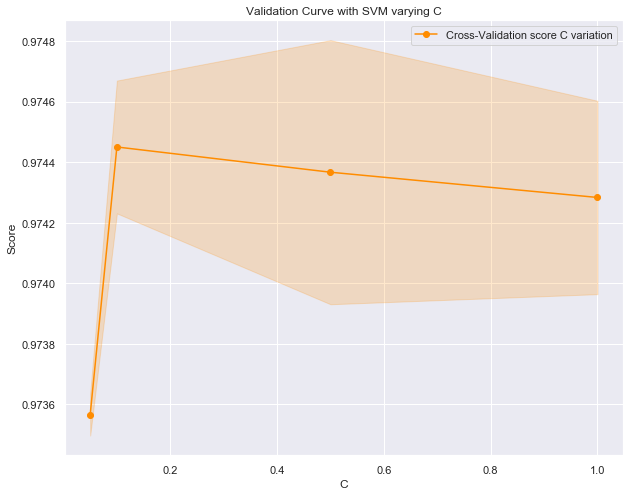

In [95]:
plot_validation_data(grid_search.cv_results_,"gamma","C",grid_search.best_params_['gamma'],c_space,"Validation Curve with SVM varying C",\
                     "C","Score","darkorange","Cross-Validation score C variation")

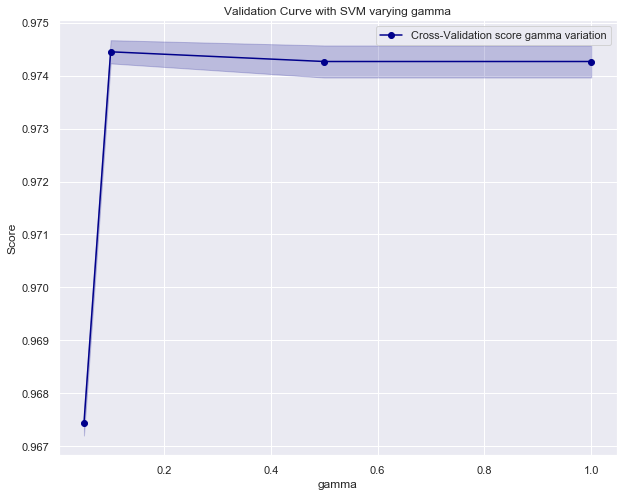

In [96]:
plot_validation_data(grid_search.cv_results_,"C","gamma",grid_search.best_params_['C'],c_space,"Validation Curve with SVM varying gamma",\
                     "gamma","Score","darkblue","Cross-Validation score gamma variation")

### Use the model fitted on (train+val) to predict on test and show results.

In [92]:
y_pred = svc.predict(x_test_svc)

Test accuracy: 98.02%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       986
           1       0.99      0.99      0.99      1125
           2       0.98      0.98      0.98       999
           3       0.97      0.97      0.97      1020
           4       0.98      0.98      0.98       975
           5       0.97      0.98      0.98       902
           6       0.99      0.99      0.99       982
           7       0.98      0.98      0.98      1042
           8       0.98      0.97      0.97       975
           9       0.97      0.97      0.97       994

   micro avg       0.98      0.98      0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

Confidence Matrix:
 [[ 980    1    0    1    0    0    1    0    1    2]
 [   0 1117    3    0    1    1    1    1    1    0]
 [   2    0  975    6    3    1    1    8    2    1]
 [   1    1    4

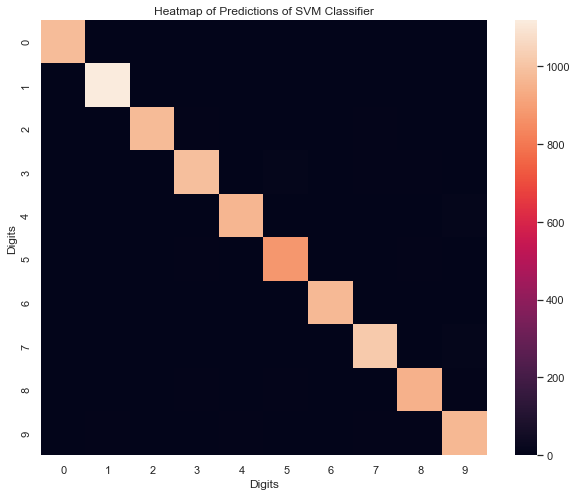

In [97]:
display_classification_results(y_test_svc, y_pred,title="Heatmap of Predictions of SVM Classifier")

### 2.1.5: Summary

Summarize your findings:
 * Which hyper-parameters were important and how did they influence your results?
 > *The hyperparameters for SVM classifier that were important were the paramaters C, and gamma. As we saw from the plots above, the C parameter and gamma both influenced our results. We can see from the cross-validation results and the validation plots that as C increases, the training accuracy for all runs go to 1.0, whereas the validation accuracy drops. This means that as C increases the model overits. On the other hand, the lowest value of C had poor validation score and a comparatively low training score, meaning that it underfit. This can be attributed to the fact that high values of C means the margins are smaller, and hence we have a higher chance to overfit on the training data.*<br>
 > *For the value of gamma as well, we see a very similar performance. For lowest gamma, we have the worst result, and then as gamma is increased, the gamma value of 0.01 gave the best validation score, while if we kept on increasing it, the score reduced again. But for highest values of gamma, the training accuracy was 1.0. This can be because for high values of gamma, the area of influence of the support vectors is reduced greatly, resulting in more overfitting.*
 * What were other design choices you faced?
 > *Other design choice we faced was the choice of a kernel. We chose the polynomial kernel, because the RBF kernel is very slow to train, and it is also a non-linear kernel. Also we perform PCA to reduce the input dimensionality that reduces it from 784 to 332. This helps to reduce the training and evaluation time, without hurting the performance much.*
 * Any other interesting insights...
 > *We see that even after dropping the dimensionality from 784 to 332 by using PCA, we still manage to get 98% accuracy. It shows how there was some redundancy in the high dimensionality. As mentioned in the website: http://yann.lecun.com/exdb/mnist/ a Gaussian kernel with no data preprocessing gives a result of 98.6%. Here we manage to get a respectable score of 98% even after reducing the data dimension and a poly kernel.*

# 2.2: Model [M2]: *2-layer Perceptron*

#### Short description : *We use an Multilayered Perceptron (2 layers) to perform the multiclass classification task. We use keras to create the MLP model and scikit-learn grid search cross validation to perform hyperparameter selection of the some of the important hyperparameters.*



### 2.2.1: Hyper-parameters

Define hyper-parameters for your method here

In [46]:
### 2.1.1: Hyper-parameters

Define hyper-parameters for your method here# Define the parameter space
epochs = np.arange(10,40,10)
#epochs = [30,]
#batch_size = np.arange(100,250,50)
activations = ["sigmoid","relu"]
optimizer_algos = ["sgd","adam"]
## learning_rate
#learning_rate = [0.001, 0.01, 0.1]
num_neurons = [256,512,INPUT_DIMENSION, 1024]
dropout_rate = [0.0,0.3,0.5]

param_space = {"epochs":epochs,\
               #"batch_size": batch_size,\
               "activation": activations,\
               "optimizer_algo": optimizer_algos,\
               #"learning_rate": learning_rate,\
               "num_neurons": num_neurons,\
               "dropout": dropout_rate,
              }

### 2.2.2: Model

Define your model here (all hyper-parameters in 2.1.1)

In [12]:
# Method to create a Keras model. We call it inside sklearn GridSearchCV for easy cross validation.
def create_mlp_model(num_neurons=256,activation='relu',optimizer_algo='sgd',dropout=0.0, learning_rate=0.01):
    # create our model
    model = Sequential()
    # Hidden Layer 1
    model.add(Dense(units=num_neurons, input_dim=INPUT_DIMENSION, activation=activation))
    # Dropout Layer
    model.add(Dropout(dropout))
    # Hidden Layer 2
    model.add(Dense(num_classes, activation='softmax'))
    if optimizer_algo == 'sgd':
      optimizer_algo = optimizers.SGD(lr=learning_rate)
    elif optimizer_algo == 'adam':
      optimizer_algo = optimizers.Adam(lr=learning_rate)
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer_algo, metrics=['accuracy'])
    return model

In [13]:
### 2.1.2: Model

Define your model here (all hyper-parameters in 2.1.1)# Define the Keras Model that will be used in cross validation
model = KerasClassifier(build_fn=create_mlp_model)

# Define the parameter space
#epochs = np.arange(20,40,10)

grid_search = sklearn.model_selection.GridSearchCV(estimator=model, param_grid=param_space, verbose=2, cv=2)



### 2.2.3: Fit Model

Define optimization procedure and fit your model to the data

In [14]:
grid_search_fit = grid_search.fit(x_trainval_nn, y_trainval_nn)

Fitting 2 folds for each of 144 candidates, totalling 288 fits
[CV] activation=sigmoid, dropout=0.0, epochs=10, num_neurons=256, optimizer_algo=sgd 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
30000/30000 [==============================] - 2s 67us/step - loss: 1.7291 - acc: 0.6266
Epoch 2/10
30000/30000 [==============================] - 2s 58us/step - loss: 0.9983 - acc: 0.8095
Epoch 3/10
30000/30000 [==============================] - 2s 61us/step - loss: 0.7160 - acc: 0.8423
Epoch 4/10
30000/30000 [==============================] - 2s 55us/step - loss: 0.5889 - acc: 0.8614
Epoch 5/10
30000/30000 [==============================] - 2s 76us/step - loss: 0.5178 - acc: 0.8715
Epoch 6/10
30000/30000 [==============================] - 2s 53us/step - loss: 0.4726 - acc: 0.8780
Epoch 7/10
30000/30000 [==============================] - 2s 53us/step - loss: 0.4408 - acc: 0.8840
Epoch 8/10
30000/30000 [==============================] - 2s 53us/step - loss: 0.4173 - acc: 0.8893
Epoch 9/10
30000/30000 [==============================] - 2s 53us/step - loss: 0.3995 - acc: 0.8926
Epoch 10/10
30000/30000 [==============================] - 1s 24us/step
[CV]  activation=sigmoid, dr

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.2s remaining:    0.0s


Epoch 1/10
30000/30000 [==============================] - 3s 89us/step - loss: 1.7154 - acc: 0.6347
Epoch 2/10
30000/30000 [==============================] - 2s 57us/step - loss: 0.9852 - acc: 0.8168
Epoch 3/10
30000/30000 [==============================] - 2s 55us/step - loss: 0.7070 - acc: 0.8489
Epoch 4/10
30000/30000 [==============================] - 2s 56us/step - loss: 0.5828 - acc: 0.8647
Epoch 5/10
30000/30000 [==============================] - 2s 55us/step - loss: 0.5136 - acc: 0.8734
Epoch 6/10
30000/30000 [==============================] - 2s 57us/step - loss: 0.4699 - acc: 0.8793
Epoch 7/10
30000/30000 [==============================] - 2s 61us/step - loss: 0.4393 - acc: 0.8846
Epoch 8/10
30000/30000 [==============================] - 2s 56us/step - loss: 0.4169 - acc: 0.8881
Epoch 9/10
30000/30000 [==============================] - 2s 57us/step - loss: 0.3994 - acc: 0.8899
Epoch 10/10
30000/30000 [==============================] - 1s 22us/step
[CV]  activation=sigmoid, dr

30000/30000 [==============================] - 8s 271us/step - loss: 0.5384 - acc: 0.8665
Epoch 5/10
30000/30000 [==============================] - 10s 337us/step - loss: 0.4818 - acc: 0.8739
Epoch 6/10
30000/30000 [==============================] - 10s 327us/step - loss: 0.4454 - acc: 0.8811
Epoch 7/10
30000/30000 [==============================] - 9s 309us/step - loss: 0.4208 - acc: 0.8852
Epoch 8/10
30000/30000 [==============================] - 8s 282us/step - loss: 0.4018 - acc: 0.8885
Epoch 9/10
30000/30000 [==============================] - 9s 314us/step - loss: 0.3878 - acc: 0.8911
Epoch 10/10
30000/30000 [==============================] - 2s 68us/step
[CV]  activation=sigmoid, dropout=0.0, epochs=10, num_neurons=1024, optimizer_algo=sgd, total= 1.6min
[CV] activation=sigmoid, dropout=0.0, epochs=10, num_neurons=1024, optimizer_algo=adam 
Epoch 1/10
30000/30000 [==============================] - 19s 625us/step - loss: 0.2959 - acc: 0.9160
Epoch 2/10
30000/30000 [===============

[CV] activation=sigmoid, dropout=0.0, epochs=20, num_neurons=256, optimizer_algo=adam 
Epoch 1/20
30000/30000 [==============================] - 4s 129us/step - loss: 0.2742 - acc: 0.9178
Epoch 2/20
30000/30000 [==============================] - 3s 113us/step - loss: 0.1292 - acc: 0.9607
Epoch 3/20
30000/30000 [==============================] - 3s 116us/step - loss: 0.1012 - acc: 0.9674
Epoch 4/20
30000/30000 [==============================] - 3s 113us/step - loss: 0.0865 - acc: 0.9719
Epoch 5/20
30000/30000 [==============================] - 3s 112us/step - loss: 0.0842 - acc: 0.9715
Epoch 6/20
30000/30000 [==============================] - 3s 112us/step - loss: 0.0691 - acc: 0.9771
Epoch 7/20
30000/30000 [==============================] - 4s 119us/step - loss: 0.0671 - acc: 0.9787
Epoch 8/20
30000/30000 [==============================] - 3s 111us/step - loss: 0.0622 - acc: 0.9799
Epoch 9/20
30000/30000 [==============================] - 3s 113us/step - loss: 0.0554 - acc: 0.9824
Epoc

30000/30000 [==============================] - 3s 90us/step
[CV]  activation=sigmoid, dropout=0.0, epochs=20, num_neurons=784, optimizer_algo=sgd, total= 2.9min
[CV] activation=sigmoid, dropout=0.0, epochs=20, num_neurons=784, optimizer_algo=sgd 
Epoch 1/20
30000/30000 [==============================] - 11s 378us/step - loss: 1.6341 - acc: 0.6241
Epoch 2/20
30000/30000 [==============================] - 11s 353us/step - loss: 0.8903 - acc: 0.8179
Epoch 3/20
30000/30000 [==============================] - 10s 334us/step - loss: 0.6488 - acc: 0.8519
Epoch 4/20
30000/30000 [==============================] - 10s 329us/step - loss: 0.5441 - acc: 0.8654
Epoch 5/20
30000/30000 [==============================] - 11s 370us/step - loss: 0.4863 - acc: 0.8748
Epoch 6/20
30000/30000 [==============================] - 10s 329us/step - loss: 0.4489 - acc: 0.8807
Epoch 7/20
30000/30000 [==============================] - 8s 261us/step - loss: 0.4234 - acc: 0.8848
Epoch 8/20
30000/30000 [================

30000/30000 [==============================] - 20s 656us/step - loss: 0.1001 - acc: 0.9793
Epoch 18/20
30000/30000 [==============================] - 17s 582us/step - loss: 0.0926 - acc: 0.9807
Epoch 19/20
30000/30000 [==============================] - 18s 584us/step - loss: 0.0928 - acc: 0.9815
Epoch 20/20
30000/30000 [==============================] - 3s 90us/step
[CV]  activation=sigmoid, dropout=0.0, epochs=20, num_neurons=1024, optimizer_algo=adam, total= 6.1min
[CV] activation=sigmoid, dropout=0.0, epochs=30, num_neurons=256, optimizer_algo=sgd 
Epoch 1/30
30000/30000 [==============================] - 4s 117us/step - loss: 1.7250 - acc: 0.6284
Epoch 2/30
30000/30000 [==============================] - 3s 89us/step - loss: 0.9883 - acc: 0.8160
Epoch 3/30
30000/30000 [==============================] - 3s 88us/step - loss: 0.7060 - acc: 0.8490
Epoch 4/30
30000/30000 [==============================] - 3s 88us/step - loss: 0.5811 - acc: 0.8648
Epoch 5/30
30000/30000 [=================

30000/30000 [==============================] - 5s 165us/step - loss: 0.3077 - acc: 0.9138
Epoch 24/30
30000/30000 [==============================] - 5s 155us/step - loss: 0.3052 - acc: 0.9134
Epoch 25/30
30000/30000 [==============================] - 5s 156us/step - loss: 0.3031 - acc: 0.9143
Epoch 26/30
30000/30000 [==============================] - 5s 157us/step - loss: 0.3008 - acc: 0.9149
Epoch 27/30
30000/30000 [==============================] - 5s 164us/step - loss: 0.2984 - acc: 0.9157
Epoch 28/30
30000/30000 [==============================] - 5s 151us/step - loss: 0.2966 - acc: 0.9165
Epoch 29/30
30000/30000 [==============================] - 4s 147us/step - loss: 0.2944 - acc: 0.9174
Epoch 30/30
30000/30000 [==============================] - 2s 56us/step
[CV]  activation=sigmoid, dropout=0.0, epochs=30, num_neurons=512, optimizer_algo=sgd, total= 2.4min
[CV] activation=sigmoid, dropout=0.0, epochs=30, num_neurons=512, optimizer_algo=sgd 
Epoch 1/30
30000/30000 [===============

30000/30000 [==============================] - 7s 220us/step - loss: 0.3276 - acc: 0.9054
Epoch 19/30
30000/30000 [==============================] - 7s 229us/step - loss: 0.3240 - acc: 0.9061
Epoch 20/30
30000/30000 [==============================] - 7s 223us/step - loss: 0.3206 - acc: 0.9071
Epoch 21/30
30000/30000 [==============================] - 7s 222us/step - loss: 0.3179 - acc: 0.9081
Epoch 22/30
30000/30000 [==============================] - 7s 238us/step - loss: 0.3150 - acc: 0.9081
Epoch 23/30
30000/30000 [==============================] - 7s 223us/step - loss: 0.3126 - acc: 0.9098
Epoch 24/30
30000/30000 [==============================] - 7s 220us/step - loss: 0.3105 - acc: 0.9089
Epoch 25/30
30000/30000 [==============================] - 7s 234us/step - loss: 0.3080 - acc: 0.9109
Epoch 26/30
30000/30000 [==============================] - 7s 219us/step - loss: 0.3056 - acc: 0.9112
Epoch 27/30
30000/30000 [==============================] - 6s 215us/step - loss: 0.3039 - acc:

30000/30000 [==============================] - 3s 88us/step
[CV]  activation=sigmoid, dropout=0.0, epochs=30, num_neurons=784, optimizer_algo=adam, total= 6.7min
[CV] activation=sigmoid, dropout=0.0, epochs=30, num_neurons=1024, optimizer_algo=sgd 
Epoch 1/30
30000/30000 [==============================] - 11s 377us/step - loss: 1.6242 - acc: 0.6142
Epoch 2/30
30000/30000 [==============================] - 9s 288us/step - loss: 0.8820 - acc: 0.8180
Epoch 3/30
30000/30000 [==============================] - 9s 288us/step - loss: 0.6431 - acc: 0.8510
Epoch 4/30
30000/30000 [==============================] - 9s 288us/step - loss: 0.5398 - acc: 0.8655
Epoch 5/30
30000/30000 [==============================] - 8s 283us/step - loss: 0.4818 - acc: 0.8752
Epoch 6/30
30000/30000 [==============================] - 9s 284us/step - loss: 0.4454 - acc: 0.8827
Epoch 7/30
30000/30000 [==============================] - 8s 282us/step - loss: 0.4197 - acc: 0.8867
Epoch 8/30
30000/30000 [===================

[CV] activation=sigmoid, dropout=0.3, epochs=10, num_neurons=256, optimizer_algo=adam 
Epoch 1/10
30000/30000 [==============================] - 6s 199us/step - loss: 0.3198 - acc: 0.9023
Epoch 2/10
30000/30000 [==============================] - 5s 152us/step - loss: 0.1827 - acc: 0.9447
Epoch 3/10
30000/30000 [==============================] - 5s 156us/step - loss: 0.1556 - acc: 0.9521
Epoch 4/10
30000/30000 [==============================] - 5s 152us/step - loss: 0.1458 - acc: 0.9556
Epoch 5/10
30000/30000 [==============================] - 5s 152us/step - loss: 0.1316 - acc: 0.9583
Epoch 6/10
30000/30000 [==============================] - 4s 147us/step - loss: 0.1249 - acc: 0.9607
Epoch 7/10
30000/30000 [==============================] - 4s 147us/step - loss: 0.1105 - acc: 0.9651
Epoch 8/10
30000/30000 [==============================] - 4s 145us/step - loss: 0.1102 - acc: 0.9652
Epoch 9/10
30000/30000 [==============================] - 5s 152us/step - loss: 0.1109 - acc: 0.9648
Epoc

30000/30000 [==============================] - 16s 549us/step - loss: 0.2107 - acc: 0.9452
Epoch 5/10
30000/30000 [==============================] - 17s 555us/step - loss: 0.2134 - acc: 0.9474
Epoch 6/10
30000/30000 [==============================] - 17s 554us/step - loss: 0.2068 - acc: 0.9516
Epoch 7/10
30000/30000 [==============================] - 17s 559us/step - loss: 0.1999 - acc: 0.9548
Epoch 8/10
30000/30000 [==============================] - 17s 553us/step - loss: 0.2122 - acc: 0.9553
Epoch 9/10
30000/30000 [==============================] - 17s 554us/step - loss: 0.2011 - acc: 0.9593
Epoch 10/10
30000/30000 [==============================] - 3s 95us/step
[CV]  activation=sigmoid, dropout=0.3, epochs=10, num_neurons=1024, optimizer_algo=adam, total= 2.9min
[CV] activation=sigmoid, dropout=0.3, epochs=10, num_neurons=1024, optimizer_algo=adam 
Epoch 1/10
30000/30000 [==============================] - 18s 605us/step - loss: 0.3367 - acc: 0.9001
Epoch 2/10
30000/30000 [==========

Epoch 1/20
30000/30000 [==============================] - 14s 476us/step - loss: 0.3174 - acc: 0.9043
Epoch 2/20
30000/30000 [==============================] - 12s 405us/step - loss: 0.1956 - acc: 0.9419
Epoch 3/20
30000/30000 [==============================] - 11s 375us/step - loss: 0.1699 - acc: 0.9493
Epoch 4/20
30000/30000 [==============================] - 11s 371us/step - loss: 0.1553 - acc: 0.9529
Epoch 5/20
30000/30000 [==============================] - 12s 399us/step - loss: 0.1444 - acc: 0.9556
Epoch 6/20
30000/30000 [==============================] - 13s 440us/step - loss: 0.1368 - acc: 0.9598
Epoch 7/20
30000/30000 [==============================] - 13s 428us/step - loss: 0.1279 - acc: 0.9629
Epoch 8/20
30000/30000 [==============================] - 13s 434us/step - loss: 0.1284 - acc: 0.9634
Epoch 9/20
30000/30000 [==============================] - 14s 454us/step - loss: 0.1299 - acc: 0.96441s
Epoch 10/20
30000/30000 [==============================] - 13s 443us/step - loss

D:\Anaconda3\envs\cysecml\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189745). Check your callbacks.
  % delta_t_median)


30000/30000 [==============================] - 11s 383us/step - loss: 0.1004 - acc: 0.9733
Epoch 20/20
30000/30000 [==============================] - 2s 77us/step
[CV]  activation=sigmoid, dropout=0.3, epochs=20, num_neurons=512, optimizer_algo=adam, total= 4.4min
[CV] activation=sigmoid, dropout=0.3, epochs=20, num_neurons=512, optimizer_algo=adam 
Epoch 1/20
30000/30000 [==============================] - 16s 521us/step - loss: 0.3176 - acc: 0.90171s - loss
Epoch 2/20
30000/30000 [==============================] - 11s 360us/step - loss: 0.1914 - acc: 0.9411
Epoch 3/20
30000/30000 [==============================] - 10s 343us/step - loss: 0.1740 - acc: 0.9488
Epoch 4/20
30000/30000 [==============================] - 9s 303us/step - loss: 0.1690 - acc: 0.9502
Epoch 5/20
30000/30000 [==============================] - 10s 322us/step - loss: 0.1454 - acc: 0.9573
Epoch 6/20
30000/30000 [==============================] - 11s 375us/step - loss: 0.1433 - acc: 0.9580
Epoch 7/20
30000/30000 [====

D:\Anaconda3\envs\cysecml\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.479571). Check your callbacks.
  % delta_t_median)
D:\Anaconda3\envs\cysecml\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240285). Check your callbacks.
  % delta_t_median)


30000/30000 [==============================] - 20s 652us/step - loss: 0.1693 - acc: 0.9615
Epoch 11/20
30000/30000 [==============================] - 16s 517us/step - loss: 0.1666 - acc: 0.9639
Epoch 12/20
30000/30000 [==============================] - 15s 490us/step - loss: 0.1714 - acc: 0.9619
Epoch 13/20
30000/30000 [==============================] - 14s 454us/step - loss: 0.1651 - acc: 0.9646
Epoch 14/20
30000/30000 [==============================] - 14s 471us/step - loss: 0.1345 - acc: 0.9702
Epoch 15/20
30000/30000 [==============================] - 14s 458us/step - loss: 0.1558 - acc: 0.9658
Epoch 16/20
30000/30000 [==============================] - 14s 472us/step - loss: 0.1356 - acc: 0.9702
Epoch 17/20
30000/30000 [==============================] - 15s 486us/step - loss: 0.1458 - acc: 0.9697
Epoch 18/20
30000/30000 [==============================] - 14s 467us/step - loss: 0.1565 - acc: 0.9690
Epoch 19/20
30000/30000 [==============================] - 14s 462us/step - loss: 0.1

30000/30000 [==============================] - 5s 153us/step - loss: 0.3490 - acc: 0.8968
Epoch 30/30
30000/30000 [==============================] - 2s 76us/step
[CV]  activation=sigmoid, dropout=0.3, epochs=30, num_neurons=256, optimizer_algo=sgd, total= 2.5min
[CV] activation=sigmoid, dropout=0.3, epochs=30, num_neurons=256, optimizer_algo=sgd 
Epoch 1/30
30000/30000 [==============================] - 7s 223us/step - loss: 1.8201 - acc: 0.4238
Epoch 2/30
30000/30000 [==============================] - 5s 155us/step - loss: 1.1351 - acc: 0.6929
Epoch 3/30
30000/30000 [==============================] - 5s 160us/step - loss: 0.8504 - acc: 0.7640
Epoch 4/30
30000/30000 [==============================] - 5s 151us/step - loss: 0.7127 - acc: 0.7977
Epoch 5/30
30000/30000 [==============================] - 5s 151us/step - loss: 0.6327 - acc: 0.8181
Epoch 6/30
30000/30000 [==============================] - 5s 153us/step - loss: 0.5807 - acc: 0.8321
Epoch 7/30
30000/30000 [=====================

30000/30000 [==============================] - 7s 225us/step - loss: 0.3691 - acc: 0.8880
Epoch 25/30
30000/30000 [==============================] - 7s 217us/step - loss: 0.3695 - acc: 0.8897
Epoch 26/30
30000/30000 [==============================] - 5s 183us/step - loss: 0.3639 - acc: 0.8907
Epoch 27/30
30000/30000 [==============================] - 5s 180us/step - loss: 0.3652 - acc: 0.8903
Epoch 28/30
30000/30000 [==============================] - 6s 190us/step - loss: 0.3596 - acc: 0.8933
Epoch 29/30
30000/30000 [==============================] - 5s 180us/step - loss: 0.3541 - acc: 0.8943
Epoch 30/30
30000/30000 [==============================] - 2s 73us/step
[CV]  activation=sigmoid, dropout=0.3, epochs=30, num_neurons=512, optimizer_algo=sgd, total= 3.4min
[CV] activation=sigmoid, dropout=0.3, epochs=30, num_neurons=512, optimizer_algo=adam 
Epoch 1/30
30000/30000 [==============================] - 11s 378us/step - loss: 0.3155 - acc: 0.9036
Epoch 2/30
30000/30000 [==============

30000/30000 [==============================] - 14s 479us/step - loss: 0.1265 - acc: 0.96971s - loss:
Epoch 17/30
30000/30000 [==============================] - 14s 481us/step - loss: 0.1306 - acc: 0.9701
Epoch 18/30
30000/30000 [==============================] - 15s 501us/step - loss: 0.1298 - acc: 0.97210s - loss: 0.1304 -
Epoch 19/30
30000/30000 [==============================] - 14s 471us/step - loss: 0.1270 - acc: 0.9716
Epoch 20/30
30000/30000 [==============================] - ETA: 0s - loss: 0.1213 - acc: 0.972 - 14s 464us/step - loss: 0.1213 - acc: 0.9726
Epoch 21/30
30000/30000 [==============================] - 14s 459us/step - loss: 0.1354 - acc: 0.9723
Epoch 22/30
30000/30000 [==============================] - 14s 467us/step - loss: 0.1480 - acc: 0.9706
Epoch 23/30
30000/30000 [==============================] - 14s 470us/step - loss: 0.1329 - acc: 0.9735
Epoch 24/30
30000/30000 [==============================] - 14s 469us/step - loss: 0.1281 - acc: 0.9753
Epoch 25/30
30000/

30000/30000 [==============================] - 21s 690us/step - loss: 0.1988 - acc: 0.9524
Epoch 7/30
30000/30000 [==============================] - 21s 693us/step - loss: 0.1956 - acc: 0.9558
Epoch 8/30
30000/30000 [==============================] - 21s 687us/step - loss: 0.1952 - acc: 0.9572
Epoch 9/30
30000/30000 [==============================] - 21s 714us/step - loss: 0.1913 - acc: 0.9597
Epoch 10/30
30000/30000 [==============================] - 21s 695us/step - loss: 0.2079 - acc: 0.9597
Epoch 11/30
30000/30000 [==============================] - 21s 695us/step - loss: 0.1985 - acc: 0.9632
Epoch 12/30
30000/30000 [==============================] - 21s 690us/step - loss: 0.1946 - acc: 0.9622
Epoch 13/30
30000/30000 [==============================] - 21s 691us/step - loss: 0.1699 - acc: 0.9678
Epoch 14/30
30000/30000 [==============================] - 21s 690us/step - loss: 0.1642 - acc: 0.9679
Epoch 15/30
30000/30000 [==============================] - 21s 697us/step - loss: 0.1489

30000/30000 [==============================] - 15s 504us/step - loss: 0.2387 - acc: 0.9296
Epoch 4/10
30000/30000 [==============================] - 15s 504us/step - loss: 0.2395 - acc: 0.9336
Epoch 5/10
30000/30000 [==============================] - 15s 505us/step - loss: 0.2306 - acc: 0.9382
Epoch 6/10
30000/30000 [==============================] - 15s 502us/step - loss: 0.2174 - acc: 0.9429
Epoch 7/10
30000/30000 [==============================] - 15s 498us/step - loss: 0.2145 - acc: 0.94522s - loss - ETA: 0s - loss: 0.2153 
Epoch 8/10
30000/30000 [==============================] - 15s 512us/step - loss: 0.2222 - acc: 0.9436
Epoch 9/10
30000/30000 [==============================] - 15s 498us/step - loss: 0.2064 - acc: 0.94770s - loss: 0.2067 - ac
Epoch 10/10
30000/30000 [==============================] - 4s 120us/step
[CV]  activation=sigmoid, dropout=0.5, epochs=10, num_neurons=784, optimizer_algo=adam, total= 2.7min
[CV] activation=sigmoid, dropout=0.5, epochs=10, num_neurons=784,

30000/30000 [==============================] - 6s 196us/step - loss: 0.1507 - acc: 0.9540
Epoch 14/20
30000/30000 [==============================] - 6s 202us/step - loss: 0.1494 - acc: 0.9555
Epoch 15/20
30000/30000 [==============================] - 6s 194us/step - loss: 0.1421 - acc: 0.9577
Epoch 16/20
30000/30000 [==============================] - 6s 194us/step - loss: 0.1423 - acc: 0.9589
Epoch 17/20
30000/30000 [==============================] - 6s 193us/step - loss: 0.1426 - acc: 0.9582
Epoch 18/20
30000/30000 [==============================] - 6s 193us/step - loss: 0.1399 - acc: 0.9591
Epoch 19/20
30000/30000 [==============================] - 6s 194us/step - loss: 0.1304 - acc: 0.9610
Epoch 20/20
30000/30000 [==============================] - 3s 88us/step
[CV]  activation=sigmoid, dropout=0.5, epochs=20, num_neurons=256, optimizer_algo=adam, total= 2.1min
[CV] activation=sigmoid, dropout=0.5, epochs=20, num_neurons=512, optimizer_algo=sgd 
Epoch 1/20
30000/30000 [==============

30000/30000 [==============================] - 16s 527us/step - loss: 0.2196 - acc: 0.95080s - loss: 0.2196 
Epoch 11/20
30000/30000 [==============================] - 16s 523us/step - loss: 0.2119 - acc: 0.9518
Epoch 12/20
30000/30000 [==============================] - 16s 527us/step - loss: 0.2106 - acc: 0.9522
Epoch 13/20
30000/30000 [==============================] - 16s 521us/step - loss: 0.1991 - acc: 0.95370s - loss: 0.1987 - acc: 0.9
Epoch 14/20
30000/30000 [==============================] - 16s 523us/step - loss: 0.2046 - acc: 0.9545
Epoch 15/20
30000/30000 [==============================] - 16s 536us/step - loss: 0.1989 - acc: 0.95633s - lo -
Epoch 16/20
30000/30000 [==============================] - 16s 525us/step - loss: 0.1939 - acc: 0.9572
Epoch 17/20
30000/30000 [==============================] - 16s 531us/step - loss: 0.2055 - acc: 0.9577
Epoch 18/20
30000/30000 [==============================] - 16s 522us/step - loss: 0.2087 - acc: 0.9570
Epoch 19/20
30000/30000 [=====

30000/30000 [==============================] - 5s 173us/step - loss: 0.4005 - acc: 0.8801
Epoch 29/30
30000/30000 [==============================] - 5s 174us/step - loss: 0.3987 - acc: 0.8823
Epoch 30/30
30000/30000 [==============================] - 3s 98us/step
[CV]  activation=sigmoid, dropout=0.5, epochs=30, num_neurons=256, optimizer_algo=sgd, total= 2.7min
[CV] activation=sigmoid, dropout=0.5, epochs=30, num_neurons=256, optimizer_algo=sgd 
Epoch 1/30
30000/30000 [==============================] - 8s 278us/step - loss: 1.9900 - acc: 0.3130
Epoch 2/30
30000/30000 [==============================] - 5s 176us/step - loss: 1.2993 - acc: 0.5961
Epoch 3/30
30000/30000 [==============================] - 5s 175us/step - loss: 1.0017 - acc: 0.6934
Epoch 4/30
30000/30000 [==============================] - 5s 175us/step - loss: 0.8358 - acc: 0.7454
Epoch 5/30
30000/30000 [==============================] - 5s 176us/step - loss: 0.7474 - acc: 0.7686
Epoch 6/30
30000/30000 [====================

30000/30000 [==============================] - 7s 234us/step - loss: 0.4152 - acc: 0.8742
Epoch 24/30
30000/30000 [==============================] - 7s 231us/step - loss: 0.4123 - acc: 0.8782
Epoch 25/30
30000/30000 [==============================] - 7s 233us/step - loss: 0.4105 - acc: 0.8762
Epoch 26/30
30000/30000 [==============================] - 7s 231us/step - loss: 0.4076 - acc: 0.8760
Epoch 27/30
30000/30000 [==============================] - 7s 229us/step - loss: 0.3944 - acc: 0.8828
Epoch 28/30
30000/30000 [==============================] - 7s 240us/step - loss: 0.3985 - acc: 0.8808
Epoch 29/30
30000/30000 [==============================] - 7s 236us/step - loss: 0.3964 - acc: 0.8814
Epoch 30/30
30000/30000 [==============================] - 3s 116us/step
[CV]  activation=sigmoid, dropout=0.5, epochs=30, num_neurons=512, optimizer_algo=sgd, total= 3.7min
[CV] activation=sigmoid, dropout=0.5, epochs=30, num_neurons=512, optimizer_algo=adam 
Epoch 1/30
30000/30000 [=============

30000/30000 [==============================] - 16s 548us/step - loss: 0.1869 - acc: 0.9585
Epoch 16/30
30000/30000 [==============================] - 16s 537us/step - loss: 0.1728 - acc: 0.9608
Epoch 17/30
30000/30000 [==============================] - 17s 554us/step - loss: 0.1765 - acc: 0.9580
Epoch 18/30
30000/30000 [==============================] - 16s 538us/step - loss: 0.1613 - acc: 0.9630
Epoch 19/30
30000/30000 [==============================] - 16s 537us/step - loss: 0.1817 - acc: 0.9601
Epoch 20/30
30000/30000 [==============================] - 17s 551us/step - loss: 0.1901 - acc: 0.9588
Epoch 21/30
30000/30000 [==============================] - 16s 542us/step - loss: 0.2014 - acc: 0.9592
Epoch 22/30
30000/30000 [==============================] - 16s 548us/step - loss: 0.1826 - acc: 0.9609
Epoch 23/30
30000/30000 [==============================] - 16s 540us/step - loss: 0.1939 - acc: 0.9606
Epoch 24/30
30000/30000 [==============================] - 16s 543us/step - loss: 0.1

30000/30000 [==============================] - 21s 710us/step - loss: 0.2842 - acc: 0.9366
Epoch 7/30
30000/30000 [==============================] - 21s 688us/step - loss: 0.2593 - acc: 0.9442
Epoch 8/30
30000/30000 [==============================] - 21s 691us/step - loss: 0.2465 - acc: 0.94551s - loss: 0
Epoch 9/30
30000/30000 [==============================] - 20s 681us/step - loss: 0.2567 - acc: 0.9462
Epoch 10/30
30000/30000 [==============================] - 21s 692us/step - loss: 0.2615 - acc: 0.9478
Epoch 11/30
30000/30000 [==============================] - 20s 682us/step - loss: 0.2603 - acc: 0.9487
Epoch 12/30
30000/30000 [==============================] - 21s 696us/step - loss: 0.2488 - acc: 0.9510
Epoch 13/30
30000/30000 [==============================] - 20s 682us/step - loss: 0.2620 - acc: 0.9527
Epoch 14/30
30000/30000 [==============================] - 21s 695us/step - loss: 0.2443 - acc: 0.9549
Epoch 15/30
30000/30000 [==============================] - 21s 685us/step - 

30000/30000 [==============================] - 16s 548us/step - loss: 0.1567 - acc: 0.9582
Epoch 4/10
30000/30000 [==============================] - 16s 536us/step - loss: 0.1300 - acc: 0.9647
Epoch 5/10
30000/30000 [==============================] - 16s 531us/step - loss: 0.1245 - acc: 0.9700
Epoch 6/10
30000/30000 [==============================] - 15s 491us/step - loss: 0.1089 - acc: 0.9724
Epoch 7/10
30000/30000 [==============================] - 15s 492us/step - loss: 0.1035 - acc: 0.9740
Epoch 8/10
30000/30000 [==============================] - 15s 493us/step - loss: 0.1067 - acc: 0.97521s - l
Epoch 9/10
30000/30000 [==============================] - 14s 481us/step - loss: 0.0922 - acc: 0.9786
Epoch 10/10
30000/30000 [==============================] - 4s 134us/step
[CV]  activation=relu, dropout=0.0, epochs=10, num_neurons=784, optimizer_algo=adam, total= 2.8min
[CV] activation=relu, dropout=0.0, epochs=10, num_neurons=784, optimizer_algo=adam 
Epoch 1/10
30000/30000 [===========

Epoch 3/20
30000/30000 [==============================] - 5s 173us/step - loss: 0.3399 - acc: 0.9081
Epoch 4/20
30000/30000 [==============================] - 5s 172us/step - loss: 0.3060 - acc: 0.9176
Epoch 5/20
30000/30000 [==============================] - 5s 171us/step - loss: 0.2829 - acc: 0.9229
Epoch 6/20
30000/30000 [==============================] - 5s 171us/step - loss: 0.2646 - acc: 0.9281
Epoch 7/20
30000/30000 [==============================] - 5s 175us/step - loss: 0.2498 - acc: 0.9320
Epoch 8/20
30000/30000 [==============================] - 5s 162us/step - loss: 0.2366 - acc: 0.9355
Epoch 9/20
30000/30000 [==============================] - 5s 163us/step - loss: 0.2251 - acc: 0.9397
Epoch 10/20
30000/30000 [==============================] - 5s 163us/step - loss: 0.2146 - acc: 0.9424
Epoch 11/20
30000/30000 [==============================] - 5s 162us/step - loss: 0.2052 - acc: 0.9449
Epoch 12/20
30000/30000 [==============================] - 5s 161us/step - loss: 0.1966 -

30000/30000 [==============================] - 10s 344us/step - loss: 0.1778 - acc: 0.9516
Epoch 3/20
30000/30000 [==============================] - 10s 341us/step - loss: 0.1583 - acc: 0.9575
Epoch 4/20
30000/30000 [==============================] - 11s 351us/step - loss: 0.1296 - acc: 0.9661
Epoch 5/20
30000/30000 [==============================] - 10s 339us/step - loss: 0.1166 - acc: 0.9702
Epoch 6/20
30000/30000 [==============================] - 10s 336us/step - loss: 0.1119 - acc: 0.9711
Epoch 7/20
30000/30000 [==============================] - 10s 337us/step - loss: 0.1111 - acc: 0.9722
Epoch 8/20
30000/30000 [==============================] - 10s 346us/step - loss: 0.1002 - acc: 0.9749
Epoch 9/20
30000/30000 [==============================] - 10s 338us/step - loss: 0.0958 - acc: 0.9775
Epoch 10/20
30000/30000 [==============================] - 10s 338us/step - loss: 0.1027 - acc: 0.9769
Epoch 11/20
30000/30000 [==============================] - 11s 354us/step - loss: 0.1020 - a

30000/30000 [==============================] - 11s 370us/step - loss: 0.1439 - acc: 0.96060s - loss: 0.1444 - acc:  - ETA: 0s - loss: 0.1441 - acc: 0.9
Epoch 18/20
30000/30000 [==============================] - 11s 376us/step - loss: 0.1381 - acc: 0.9624
Epoch 19/20
30000/30000 [==============================] - 11s 368us/step - loss: 0.1331 - acc: 0.9637
Epoch 20/20
30000/30000 [==============================] - 5s 160us/step
[CV]  activation=relu, dropout=0.0, epochs=20, num_neurons=1024, optimizer_algo=sgd, total= 3.9min
[CV] activation=relu, dropout=0.0, epochs=20, num_neurons=1024, optimizer_algo=adam 
Epoch 1/20
30000/30000 [==============================] - 23s 769us/step - loss: 0.3048 - acc: 0.91200s - loss: 0.3072 - acc: 
Epoch 2/20
30000/30000 [==============================] - 19s 619us/step - loss: 0.1935 - acc: 0.9482
Epoch 3/20
30000/30000 [==============================] - 19s 627us/step - loss: 0.1580 - acc: 0.9577
Epoch 4/20
30000/30000 [==============================

30000/30000 [==============================] - 7s 250us/step - loss: 0.1168 - acc: 0.9696
Epoch 6/30
30000/30000 [==============================] - 8s 253us/step - loss: 0.1144 - acc: 0.9699
Epoch 7/30
30000/30000 [==============================] - 7s 239us/step - loss: 0.1081 - acc: 0.9737
Epoch 8/30
30000/30000 [==============================] - 7s 240us/step - loss: 0.1026 - acc: 0.9759
Epoch 9/30
30000/30000 [==============================] - 7s 240us/step - loss: 0.0893 - acc: 0.9784
Epoch 10/30
30000/30000 [==============================] - 8s 250us/step - loss: 0.0875 - acc: 0.9797
Epoch 11/30
30000/30000 [==============================] - 7s 240us/step - loss: 0.1065 - acc: 0.9786
Epoch 12/30
30000/30000 [==============================] - 7s 241us/step - loss: 0.0910 - acc: 0.9807
Epoch 13/30
30000/30000 [==============================] - 7s 240us/step - loss: 0.0943 - acc: 0.9813
Epoch 14/30
30000/30000 [==============================] - 7s 242us/step - loss: 0.0844 - acc: 0.9

Epoch 1/30
30000/30000 [==============================] - 14s 481us/step - loss: 0.7874 - acc: 0.8223
Epoch 2/30
30000/30000 [==============================] - 10s 333us/step - loss: 0.3886 - acc: 0.8987
Epoch 3/30
30000/30000 [==============================] - 10s 333us/step - loss: 0.3262 - acc: 0.9139
Epoch 4/30
30000/30000 [==============================] - 10s 346us/step - loss: 0.2932 - acc: 0.9218
Epoch 5/30
30000/30000 [==============================] - 10s 338us/step - loss: 0.2703 - acc: 0.9276
Epoch 6/30
30000/30000 [==============================] - 10s 327us/step - loss: 0.2521 - acc: 0.9333
Epoch 7/30
30000/30000 [==============================] - 10s 332us/step - loss: 0.2372 - acc: 0.9371
Epoch 8/30
30000/30000 [==============================] - 10s 343us/step - loss: 0.2241 - acc: 0.9401
Epoch 9/30
30000/30000 [==============================] - 10s 335us/step - loss: 0.2127 - acc: 0.9434
Epoch 10/30
30000/30000 [==============================] - 10s 327us/step - loss: 

30000/30000 [==============================] - 15s 484us/step - loss: 0.1039 - acc: 0.9735
Epoch 28/30
30000/30000 [==============================] - 15s 484us/step - loss: 0.1006 - acc: 0.9748
Epoch 29/30
30000/30000 [==============================] - 15s 486us/step - loss: 0.0976 - acc: 0.9754
Epoch 30/30
30000/30000 [==============================] - 6s 204us/step
[CV]  activation=relu, dropout=0.0, epochs=30, num_neurons=1024, optimizer_algo=sgd, total= 7.8min
[CV] activation=relu, dropout=0.0, epochs=30, num_neurons=1024, optimizer_algo=sgd 
Epoch 1/30
30000/30000 [==============================] - 20s 655us/step - loss: 0.7915 - acc: 0.82285s - ETA: 0s - loss: 0.7942 - acc: 0.8
Epoch 2/30
30000/30000 [==============================] - 15s 485us/step - loss: 0.3835 - acc: 0.8969A: 3s -  - ETA: 1s
Epoch 3/30
30000/30000 [==============================] - 15s 502us/step - loss: 0.3238 - acc: 0.9099
Epoch 4/30
30000/30000 [==============================] - 15s 490us/step - loss: 0.29

Epoch 1/10
30000/30000 [==============================] - 15s 507us/step - loss: 0.8706 - acc: 0.7734
Epoch 2/10
30000/30000 [==============================] - 10s 336us/step - loss: 0.4322 - acc: 0.8805
Epoch 3/10
30000/30000 [==============================] - 10s 335us/step - loss: 0.3648 - acc: 0.8972
Epoch 4/10
30000/30000 [==============================] - 10s 337us/step - loss: 0.3263 - acc: 0.9079
Epoch 5/10
30000/30000 [==============================] - 10s 345us/step - loss: 0.3000 - acc: 0.9158
Epoch 6/10
30000/30000 [==============================] - 10s 336us/step - loss: 0.2770 - acc: 0.9223
Epoch 7/10
30000/30000 [==============================] - 10s 340us/step - loss: 0.2599 - acc: 0.9276
Epoch 8/10
30000/30000 [==============================] - 10s 335us/step - loss: 0.2449 - acc: 0.9340
Epoch 9/10
30000/30000 [==============================] - 10s 345us/step - loss: 0.2309 - acc: 0.9354
Epoch 10/10
30000/30000 [==============================] - 5s 179us/step
[CV]  act

Epoch 1/10
30000/30000 [==============================] - 26s 876us/step - loss: 0.4136 - acc: 0.88272
Epoch 2/10
30000/30000 [==============================] - 20s 652us/step - loss: 0.3103 - acc: 0.9167
Epoch 3/10
30000/30000 [==============================] - 20s 664us/step - loss: 0.2897 - acc: 0.9263
Epoch 4/10
30000/30000 [==============================] - 20s 656us/step - loss: 0.2704 - acc: 0.9324
Epoch 5/10
30000/30000 [==============================] - 20s 660us/step - loss: 0.2560 - acc: 0.93850s - loss: 0.2559 - acc: 0.938
Epoch 6/10
30000/30000 [==============================] - 20s 660us/step - loss: 0.2543 - acc: 0.9407
Epoch 7/10
30000/30000 [==============================] - 20s 659us/step - loss: 0.2481 - acc: 0.9431
Epoch 8/10
30000/30000 [==============================] - 20s 661us/step - loss: 0.2341 - acc: 0.9455
Epoch 9/10
30000/30000 [==============================] - 20s 651us/step - loss: 0.2312 - acc: 0.9460
Epoch 10/10
30000/30000 [==========================

Epoch 1/20
30000/30000 [==============================] - 13s 429us/step - loss: 0.8922 - acc: 0.7672
Epoch 2/20
30000/30000 [==============================] - 8s 262us/step - loss: 0.4622 - acc: 0.8702
Epoch 3/20
30000/30000 [==============================] - 8s 262us/step - loss: 0.3883 - acc: 0.8907
Epoch 4/20
30000/30000 [==============================] - 8s 262us/step - loss: 0.3467 - acc: 0.9006
Epoch 5/20
30000/30000 [==============================] - 8s 270us/step - loss: 0.3177 - acc: 0.9101
Epoch 6/20
30000/30000 [==============================] - 8s 265us/step - loss: 0.2962 - acc: 0.9162
Epoch 7/20
30000/30000 [==============================] - 8s 266us/step - loss: 0.2801 - acc: 0.9218
Epoch 8/20
30000/30000 [==============================] - 8s 262us/step - loss: 0.2633 - acc: 0.9259
Epoch 9/20
30000/30000 [==============================] - 8s 262us/step - loss: 0.2484 - acc: 0.9303
Epoch 10/20
30000/30000 [==============================] - 8s 270us/step - loss: 0.2379 - 

30000/30000 [==============================] - 5s 178us/step
[CV]  activation=relu, dropout=0.3, epochs=20, num_neurons=512, optimizer_algo=adam, total= 5.3min
[CV] activation=relu, dropout=0.3, epochs=20, num_neurons=512, optimizer_algo=adam 
Epoch 1/20
30000/30000 [==============================] - 19s 630us/step - loss: 0.4095 - acc: 0.8819
Epoch 2/20
30000/30000 [==============================] - 13s 447us/step - loss: 0.3103 - acc: 0.91564s - loss: 0.3128 - ETA: 3s - los - E
Epoch 3/20
30000/30000 [==============================] - 14s 451us/step - loss: 0.2713 - acc: 0.92891s - lo
Epoch 4/20
30000/30000 [==============================] - 14s 454us/step - loss: 0.2654 - acc: 0.9339
Epoch 5/20
30000/30000 [==============================] - 14s 453us/step - loss: 0.2499 - acc: 0.9367
Epoch 6/20
30000/30000 [==============================] - 14s 455us/step - loss: 0.2585 - acc: 0.9394
Epoch 7/20
30000/30000 [==============================] - 14s 459us/step - loss: 0.2485 - acc: 0.941

30000/30000 [==============================] - 16s 527us/step - loss: 0.1965 - acc: 0.9451
Epoch 12/20
30000/30000 [==============================] - 16s 543us/step - loss: 0.1890 - acc: 0.9457
Epoch 13/20
30000/30000 [==============================] - 16s 527us/step - loss: 0.1796 - acc: 0.94970s - loss: 0.1789 - acc: 0.9
Epoch 14/20
30000/30000 [==============================] - 16s 538us/step - loss: 0.1708 - acc: 0.9508
Epoch 15/20
30000/30000 [==============================] - 16s 527us/step - loss: 0.1645 - acc: 0.9546
Epoch 16/20
30000/30000 [==============================] - 16s 529us/step - loss: 0.1593 - acc: 0.9550
Epoch 17/20
30000/30000 [==============================] - 17s 561us/step - loss: 0.1535 - acc: 0.9565
Epoch 18/20
30000/30000 [==============================] - 16s 546us/step - loss: 0.1459 - acc: 0.9592
Epoch 19/20
30000/30000 [==============================] - 17s 556us/step - loss: 0.1409 - acc: 0.9604
Epoch 20/20
30000/30000 [==============================] 

30000/30000 [==============================] - 17s 554us/step - loss: 0.3941 - acc: 0.8814
Epoch 2/30
30000/30000 [==============================] - 11s 367us/step - loss: 0.2966 - acc: 0.9149
Epoch 3/30
30000/30000 [==============================] - 11s 359us/step - loss: 0.2803 - acc: 0.9242
Epoch 4/30
30000/30000 [==============================] - 11s 360us/step - loss: 0.2609 - acc: 0.9307
Epoch 5/30
30000/30000 [==============================] - 11s 361us/step - loss: 0.2689 - acc: 0.9333
Epoch 6/30
30000/30000 [==============================] - 11s 366us/step - loss: 0.2464 - acc: 0.9364
Epoch 7/30
30000/30000 [==============================] - 11s 362us/step - loss: 0.2400 - acc: 0.9417
Epoch 8/30
30000/30000 [==============================] - 11s 360us/step - loss: 0.2376 - acc: 0.9427
Epoch 9/30
30000/30000 [==============================] - 11s 367us/step - loss: 0.2312 - acc: 0.9465
Epoch 10/30
30000/30000 [==============================] - 11s 361us/step - loss: 0.2289 - ac

30000/30000 [==============================] - 15s 484us/step - loss: 0.2125 - acc: 0.96063s - loss: 
Epoch 23/30
30000/30000 [==============================] - 15s 495us/step - loss: 0.2003 - acc: 0.96220s - loss:
Epoch 24/30
30000/30000 [==============================] - 15s 494us/step - loss: 0.2059 - acc: 0.9607
Epoch 25/30
30000/30000 [==============================] - 15s 487us/step - loss: 0.2283 - acc: 0.9620
Epoch 26/30
30000/30000 [==============================] - 15s 496us/step - loss: 0.1995 - acc: 0.96427s - loss: 0.19 - ETA:  - ETA: 5s - loss: 0.1979 - acc: - ETA: 4s - loss: 0.197 - ETA: 3s - loss: - ETA: 2s - loss: 0.1994 - acc: 0.964 - ETA: 2s - loss: 0 - ETA: 1s - loss: 0. - ETA: 0s - loss: 0.1999 - acc: 
Epoch 27/30
30000/30000 [==============================] - 15s 487us/step - loss: 0.1886 - acc: 0.9649
Epoch 28/30
30000/30000 [==============================] - 15s 483us/step - loss: 0.2203 - acc: 0.9626
Epoch 29/30
30000/30000 [==============================] - 15

30000/30000 [==============================] - 16s 541us/step - loss: 0.2881 - acc: 0.9199
Epoch 6/30
30000/30000 [==============================] - 17s 562us/step - loss: 0.2668 - acc: 0.92652s - loss: 0. - ETA: 1s - los
Epoch 7/30
30000/30000 [==============================] - 16s 539us/step - loss: 0.2509 - acc: 0.9313
Epoch 8/30
30000/30000 [==============================] - ETA: 0s - loss: 0.2362 - acc: 0.935 - 16s 547us/step - loss: 0.2361 - acc: 0.9355
Epoch 9/30
30000/30000 [==============================] - 16s 538us/step - loss: 0.2239 - acc: 0.9388
Epoch 10/30
30000/30000 [==============================] - 17s 570us/step - loss: 0.2137 - acc: 0.9410
Epoch 11/30
30000/30000 [==============================] - 19s 634us/step - loss: 0.2029 - acc: 0.94349s - loss: 0.2040 - acc: 0.9 - ETA:  - ETA: 4s - - ETA: 2s - loss: 0.2024 - 
Epoch 12/30
30000/30000 [==============================] - 17s 559us/step - loss: 0.1924 - acc: 0.9472
Epoch 13/30
30000/30000 [========================

30000/30000 [==============================] - 9s 309us/step - loss: 0.5113 - acc: 0.8545
Epoch 3/10
30000/30000 [==============================] - 9s 308us/step - loss: 0.4288 - acc: 0.8768
Epoch 4/10
30000/30000 [==============================] - 9s 308us/step - loss: 0.3780 - acc: 0.8923
Epoch 5/10
30000/30000 [==============================] - 9s 315us/step - loss: 0.3488 - acc: 0.9009
Epoch 6/10
30000/30000 [==============================] - 9s 309us/step - loss: 0.3252 - acc: 0.9069
Epoch 7/10
30000/30000 [==============================] - 9s 307us/step - loss: 0.3010 - acc: 0.9143
Epoch 8/10
30000/30000 [==============================] - 9s 309us/step - loss: 0.2874 - acc: 0.9182
Epoch 9/10
30000/30000 [==============================] - 9s 316us/step - loss: 0.2737 - acc: 0.9204
Epoch 10/10
30000/30000 [==============================] - 6s 208us/step
[CV]  activation=relu, dropout=0.5, epochs=10, num_neurons=256, optimizer_algo=sgd, total= 1.8min
[CV] activation=relu, dropout=0.

Epoch 1/10
30000/30000 [==============================] - 24s 810us/step - loss: 0.8476 - acc: 0.7788
Epoch 2/10
30000/30000 [==============================] - 19s 630us/step - loss: 0.4407 - acc: 0.87451s 
Epoch 3/10
30000/30000 [==============================] - 19s 624us/step - loss: 0.3704 - acc: 0.8937
Epoch 4/10
30000/30000 [==============================] - 19s 635us/step - loss: 0.3325 - acc: 0.90471s - loss: - ETA: 0s - loss: 0.3335 - a
Epoch 5/10
30000/30000 [==============================] - 19s 624us/step - loss: 0.3014 - acc: 0.91411s - lo
Epoch 6/10
30000/30000 [==============================] - 19s 634us/step - loss: 0.2802 - acc: 0.9203
Epoch 7/10
30000/30000 [==============================] - 19s 622us/step - loss: 0.2642 - acc: 0.9243
Epoch 8/10
30000/30000 [==============================] - 19s 625us/step - loss: 0.2474 - acc: 0.92970s - loss: 0.247
Epoch 9/10
30000/30000 [==============================] - 18s 616us/step - loss: 0.2308 - acc: 0.9343
Epoch 10/10
30000

30000/30000 [==============================] - 10s 327us/step - loss: 0.2032 - acc: 0.9410
Epoch 18/20
30000/30000 [==============================] - 10s 327us/step - loss: 0.1992 - acc: 0.9428
Epoch 19/20
30000/30000 [==============================] - 10s 336us/step - loss: 0.1943 - acc: 0.9445
Epoch 20/20
30000/30000 [==============================] - 7s 230us/step
[CV]  activation=relu, dropout=0.5, epochs=20, num_neurons=256, optimizer_algo=sgd, total= 3.7min
[CV] activation=relu, dropout=0.5, epochs=20, num_neurons=256, optimizer_algo=adam 
Epoch 1/20
30000/30000 [==============================] - 19s 634us/step - loss: 0.5051 - acc: 0.8479
Epoch 2/20
30000/30000 [==============================] - 13s 437us/step - loss: 0.4248 - acc: 0.8821
Epoch 3/20
30000/30000 [==============================] - 13s 448us/step - loss: 0.4108 - acc: 0.8909
Epoch 4/20
30000/30000 [==============================] - 13s 442us/step - loss: 0.3964 - acc: 0.8954
Epoch 5/20
30000/30000 [================

30000/30000 [==============================] - 16s 531us/step - loss: 0.2071 - acc: 0.9418
Epoch 13/20
30000/30000 [==============================] - 16s 535us/step - loss: 0.1983 - acc: 0.9456
Epoch 14/20
30000/30000 [==============================] - 16s 537us/step - loss: 0.1904 - acc: 0.9462
Epoch 15/20
30000/30000 [==============================] - 16s 544us/step - loss: 0.1850 - acc: 0.9480
Epoch 16/20
30000/30000 [==============================] - 16s 533us/step - loss: 0.1776 - acc: 0.9506
Epoch 17/20
30000/30000 [==============================] - 16s 538us/step - loss: 0.1727 - acc: 0.9523
Epoch 18/20
30000/30000 [==============================] - 16s 543us/step - loss: 0.1676 - acc: 0.9532
Epoch 19/20
30000/30000 [==============================] - 16s 550us/step - loss: 0.1610 - acc: 0.9547
Epoch 20/20
30000/30000 [==============================] - 8s 260us/step
[CV]  activation=relu, dropout=0.5, epochs=20, num_neurons=784, optimizer_algo=sgd, total= 5.8min
[CV] activation=r

30000/30000 [==============================] - 30s 998us/step - loss: 0.4389 - acc: 0.8830
Epoch 3/20
30000/30000 [==============================] - 30s 1ms/step - loss: 0.4270 - acc: 0.8950: 4s - lo
Epoch 4/20
30000/30000 [==============================] - 30s 998us/step - loss: 0.4093 - acc: 0.9007
Epoch 5/20
30000/30000 [==============================] - 30s 998us/step - loss: 0.3854 - acc: 0.90810s - loss: 0.3847 
Epoch 6/20
30000/30000 [==============================] - 30s 995us/step - loss: 0.3787 - acc: 0.9128
Epoch 7/20
30000/30000 [==============================] - 30s 991us/step - loss: 0.3873 - acc: 0.9139
Epoch 8/20
30000/30000 [==============================] - 30s 992us/step - loss: 0.3516 - acc: 0.92021s - loss: 0.3510 - acc: - ETA: 0s - loss: 0.3539 - 
Epoch 9/20
30000/30000 [==============================] - 30s 995us/step - loss: 0.3735 - acc: 0.9197
Epoch 10/20
30000/30000 [==============================] - 30s 991us/step - loss: 0.3611 - acc: 0.9206
Epoch 11/20
300

30000/30000 [==============================] - 14s 465us/step - loss: 0.3947 - acc: 0.8892
Epoch 4/30
30000/30000 [==============================] - 14s 461us/step - loss: 0.3530 - acc: 0.8998
Epoch 5/30
30000/30000 [==============================] - 14s 462us/step - loss: 0.3207 - acc: 0.9099
Epoch 6/30
30000/30000 [==============================] - 14s 467us/step - loss: 0.2954 - acc: 0.9171
Epoch 7/30
30000/30000 [==============================] - 14s 463us/step - loss: 0.2761 - acc: 0.92220s - loss: 0.276
Epoch 8/30
30000/30000 [==============================] - 14s 478us/step - loss: 0.2609 - acc: 0.9267
Epoch 9/30
30000/30000 [==============================] - 15s 507us/step - loss: 0.2498 - acc: 0.9295
Epoch 10/30
30000/30000 [==============================] - 14s 483us/step - loss: 0.2362 - acc: 0.9358
Epoch 11/30
30000/30000 [==============================] - 13s 437us/step - loss: 0.2293 - acc: 0.9360
Epoch 12/30
30000/30000 [==============================] - 14s 454us/step -

30000/30000 [==============================] - 22s 725us/step - loss: 0.1886 - acc: 0.9493
Epoch 15/30
30000/30000 [==============================] - 20s 654us/step - loss: 0.1844 - acc: 0.9485
Epoch 16/30
30000/30000 [==============================] - 19s 638us/step - loss: 0.1771 - acc: 0.9505
Epoch 17/30
30000/30000 [==============================] - 19s 640us/step - loss: 0.1707 - acc: 0.95280s - loss: 0.1717 -
Epoch 18/30
30000/30000 [==============================] - 20s 650us/step - loss: 0.1663 - acc: 0.9526
Epoch 19/30
30000/30000 [==============================] - 17s 579us/step - loss: 0.1597 - acc: 0.9561
Epoch 20/30
30000/30000 [==============================] - 18s 597us/step - loss: 0.1546 - acc: 0.9568
Epoch 21/30
30000/30000 [==============================] - 18s 615us/step - loss: 0.1512 - acc: 0.95682s - loss: 0.1539 - acc: 0. 
Epoch 22/30
30000/30000 [==============================] - 18s 614us/step - loss: 0.1451 - acc: 0.95930s - loss: 0.14
Epoch 23/30
30000/30000

30000/30000 [==============================] - 24s 813us/step - loss: 0.1275 - acc: 0.96450s - loss: 0.1273 - acc: 0
Epoch 27/30
30000/30000 [==============================] - 26s 851us/step - loss: 0.1234 - acc: 0.9654
Epoch 28/30
30000/30000 [==============================] - 26s 853us/step - loss: 0.1192 - acc: 0.9682
Epoch 29/30
30000/30000 [==============================] - 30s 1ms/step - loss: 0.1188 - acc: 0.9656: 7s  - ET - ETA: 5s - loss - ETA: 4s - l - 
Epoch 30/30
30000/30000 [==============================] - 11s 370us/step
[CV]  activation=relu, dropout=0.5, epochs=30, num_neurons=1024, optimizer_algo=sgd, total=13.3min
[CV] activation=relu, dropout=0.5, epochs=30, num_neurons=1024, optimizer_algo=sgd 
Epoch 1/30
30000/30000 [==============================] - 36s 1ms/step - loss: 0.8651 - acc: 0.7716
Epoch 2/30
30000/30000 [==============================] - 24s 785us/step - loss: 0.4416 - acc: 0.8756
Epoch 3/30
30000/30000 [==============================] - 24s 789us/step 

30000/30000 [==============================] - 34s 1ms/step - loss: 0.4045 - acc: 0.8975
Epoch 4/30
30000/30000 [==============================] - 34s 1ms/step - loss: 0.4088 - acc: 0.9030
Epoch 5/30
30000/30000 [==============================] - 34s 1ms/step - loss: 0.3994 - acc: 0.9071
Epoch 6/30
30000/30000 [==============================] - 35s 1ms/step - loss: 0.3919 - acc: 0.9113
Epoch 7/30
30000/30000 [==============================] - 36s 1ms/step - loss: 0.3852 - acc: 0.9170
Epoch 8/30
30000/30000 [==============================] - 34s 1ms/step - loss: 0.3738 - acc: 0.9181
Epoch 9/30
30000/30000 [==============================] - 34s 1ms/step - loss: 0.3851 - acc: 0.9196
Epoch 10/30
30000/30000 [==============================] - 34s 1ms/step - loss: 0.3717 - acc: 0.9220
Epoch 11/30
30000/30000 [==============================] - 34s 1ms/step - loss: 0.3815 - acc: 0.9236
Epoch 12/30
30000/30000 [==============================] - 34s 1ms/step - loss: 0.3656 - acc: 0.9218
Epoch 13

[Parallel(n_jobs=1)]: Done 288 out of 288 | elapsed: 1476.9min finished


Epoch 1/30
60000/60000 [==============================] - 61s 1ms/step - loss: 0.3374 - acc: 0.8997
Epoch 2/30
60000/60000 [==============================] - 51s 856us/step - loss: 0.2585 - acc: 0.9290
Epoch 3/30
60000/60000 [==============================] - 51s 843us/step - loss: 0.2434 - acc: 0.9359
Epoch 4/30
60000/60000 [==============================] - 51s 857us/step - loss: 0.2380 - acc: 0.9405
Epoch 5/30
60000/60000 [==============================] - 52s 862us/step - loss: 0.2393 - acc: 0.94300s - loss: 0.2384
Epoch 6/30
60000/60000 [==============================] - 52s 862us/step - loss: 0.2145 - acc: 0.9477
Epoch 7/30
60000/60000 [==============================] - 52s 866us/step - loss: 0.2137 - acc: 0.9485
Epoch 8/30
60000/60000 [==============================] - 51s 846us/step - loss: 0.2030 - acc: 0.9517
Epoch 9/30
60000/60000 [==============================] - 51s 844us/step - loss: 0.1976 - acc: 0.9531
Epoch 10/30
60000/60000 [==============================] - 51s 856u

In [26]:
# summarize results
print("Best Validation Accuracy Score from CV: %.2f%% using %s" % ((100*grid_search_fit.best_score_), grid_search_fit.best_params_))

Best Validation Accuracy Score from CV: 97.24% using {'activation': 'sigmoid', 'dropout': 0.5, 'epochs': 30, 'num_neurons': 784, 'optimizer_algo': 'adam'}


In [52]:
print(grid_search_fit.cv_results_)
sys.setrecursionlimit(300000)
with open('mlp_grid_search_cv_results.pickle', 'wb') as handle:
    pickle.dump(grid_search_fit.cv_results_, handle, protocol=pickle.HIGHEST_PROTOCOL)

{'mean_fit_time': array([  18.35012329,   38.90721452,   54.45113087,   98.41866636,
         75.98988795,  137.59147894,   91.04404223,  176.71902561,
         38.84992111,   70.77791727,   88.41152477,  231.98152554,
        171.3811605 ,  324.00426853,  192.63055325,  381.47989011,
         72.13069952,  119.23986983,  139.11549342,  250.35243809,
        202.74002504,  386.00446618,  267.54767787,  508.16244376,
         32.59298944,   45.89766955,   55.32063389,   88.90156686,
         77.55560124,  131.75551927,   94.90850747,  169.15433502,
         70.68764532,  102.38776886,  161.16102338,  229.21274757,
        205.19938505,  307.65329862,  236.20360732,  482.31411624,
        135.3106432 ,  178.39199567,  189.82958114,  299.96988237,
        242.34379482,  470.80326533,  347.85084438,  651.03312516,
         44.03293002,   56.4422009 ,   65.93471849,  104.22960114,
         89.20106757,  154.92654133,  111.6268419 ,  199.38199925,
         94.85861504,  120.73370552,  137.50

#### We fit model with best CV parameters on (train+val) .

In [71]:
# build the model
#model = create_mlp_model(activation="relu",dropout=0.5,num_neurons=784,optimizer_algo="adam")
model = create_mlp_model(activation=grid_search_fit.best_params_['activation'], \
                         dropout=grid_search_fit.best_params_['dropout'], \
                         num_neurons=grid_search_fit.best_params_['num_neurons'], \
                         optimizer_algo=grid_search_fit.best_params_['optimizer_algo'])
# Fit the model

# This is the final fit on entire data, so that we can get the test accuracy.
fit_model_final = model.fit(x_trainval_nn, y_trainval_nn, validation_data=(x_test_nn, y_test_nn), epochs=grid_search_fit.best_params_['epochs'], batch_size=200, verbose=0)

### 2.2.4: Evaluation

Evaluate your model.

When possible, you should have:
  * Loss curves: Plot epoch (# passes over training data) and loss
  * Accuracy curves: Plot epoch and accuracy over val/test set
  * Final numbers: Report final accuracy numbers for your model

In [58]:
idx_varying_num_neurons_sgd = []
idx_varying_num_neurons_adam = []
for i in range(len(grid_search_fit.cv_results_['params'])):
    param = grid_search_fit.cv_results_['params'][i]
    if param['activation'] == grid_search_fit.best_params_['activation']\
     and param['dropout'] == grid_search_fit.best_params_['dropout']\
     and param['epochs'] == grid_search_fit.best_params_['epochs']:
        if param['optimizer_algo'] == 'sgd':
            idx_varying_num_neurons_sgd.append(i)
        elif param['optimizer_algo'] == 'adam':
            idx_varying_num_neurons_adam.append(i)

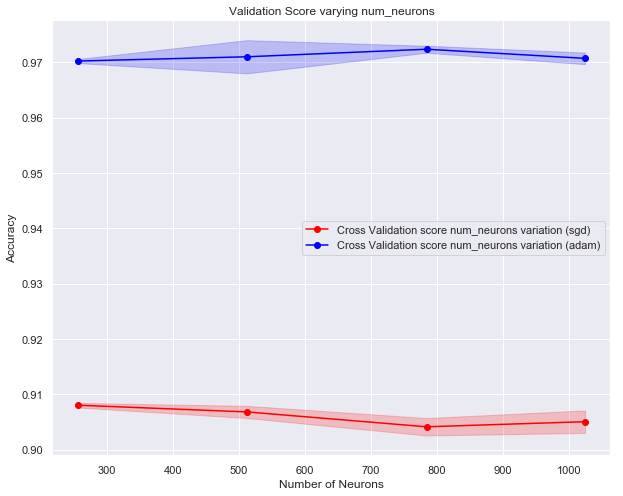

In [76]:
test_scores_mean_sgd = grid_search_fit.cv_results_['mean_test_score'][idx_varying_num_neurons_sgd]
test_scores_std_sgd = grid_search_fit.cv_results_['std_test_score'][idx_varying_num_neurons_sgd]

test_scores_mean_adam = grid_search_fit.cv_results_['mean_test_score'][idx_varying_num_neurons_adam]
test_scores_std_adam = grid_search_fit.cv_results_['std_test_score'][idx_varying_num_neurons_adam]

plt.title('Validation Score varying num_neurons')
plt.xlabel('Number of Neurons')
plt.ylabel('Accuracy')

plt.plot(num_neurons, test_scores_mean_sgd,'o-', label="Cross Validation score num_neurons variation (sgd)",
         color='red')
plt.fill_between(num_neurons, test_scores_mean_sgd - test_scores_std_sgd,
             test_scores_mean_sgd + test_scores_std_sgd, alpha=0.2,
             color='red')

plt.plot(num_neurons, test_scores_mean_adam,'o-', label="Cross Validation score num_neurons variation (adam)",
         color='blue')
plt.fill_between(num_neurons, test_scores_mean_adam - test_scores_std_adam,
             test_scores_mean_adam + test_scores_std_adam, alpha=0.2,
             color='blue')

plt.legend(loc="best")
plt.show()

#### Use the model fitted on (train+val) with best CV parameters.

In [72]:
y_pred = model.predict(x_test_nn)
y_pred = np.argmax(y_pred, axis=1)

#### Now use the val history to plot loss and accuracy curves

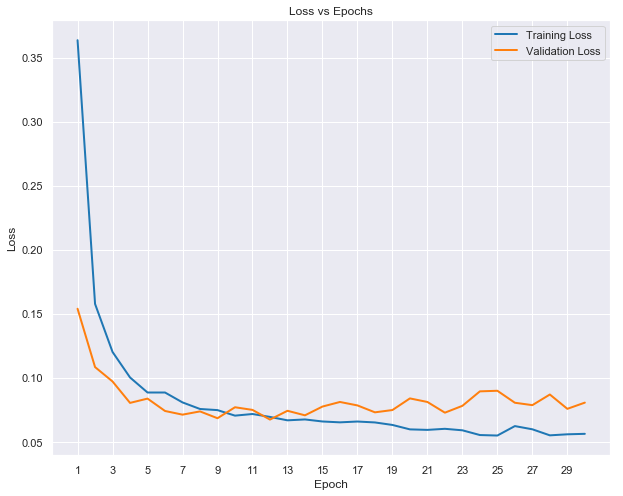

In [73]:
sns.set_context("notebook")
sns.set_style("darkgrid")

plt.plot(range(1,epochs[-1]+1),fit_model_final.history['loss'],label='Training Loss',linewidth=2.0)
plt.plot(range(1,epochs[-1]+1),fit_model_final.history['val_loss'],label='Validation Loss',linewidth=2.0)
plt.xticks(range(1,epochs[-1]+1,2));
plt.legend(loc='best')
plt.title('Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

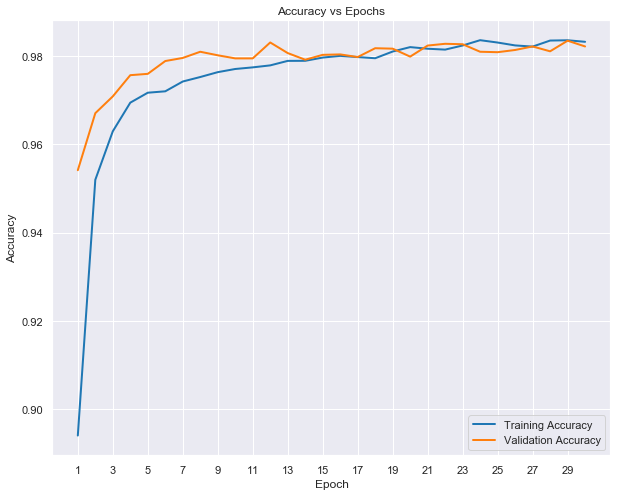

In [74]:
sns.set_context("notebook")
sns.set_style("darkgrid")

plt.plot(range(1,epochs[-1]+1),fit_model_final.history['acc'],label='Training Accuracy',linewidth=2.0)
plt.plot(range(1,epochs[-1]+1),fit_model_final.history['val_acc'],label='Validation Accuracy',linewidth=2.0)
plt.xticks(range(1,epochs[-1]+1,2));
plt.legend(loc='best')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

#### Show prediction report on test data. Training on (train+val)

Test accuracy: 98.21%
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       986
           1       0.99      0.99      0.99      1125
           2       0.98      0.98      0.98       999
           3       0.98      0.97      0.98      1020
           4       0.98      0.99      0.98       975
           5       0.97      0.99      0.98       902
           6       0.99      0.99      0.99       982
           7       0.98      0.98      0.98      1042
           8       0.98      0.97      0.98       975
           9       0.98      0.96      0.97       994

   micro avg       0.98      0.98      0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

Confidence Matrix:
 [[ 983    1    0    0    0    0    1    0    1    0]
 [   0 1117    3    1    1    0    0    2    1    0]
 [   2    0  981    5    3    0    0    2    5    1]
 [   1    1    5

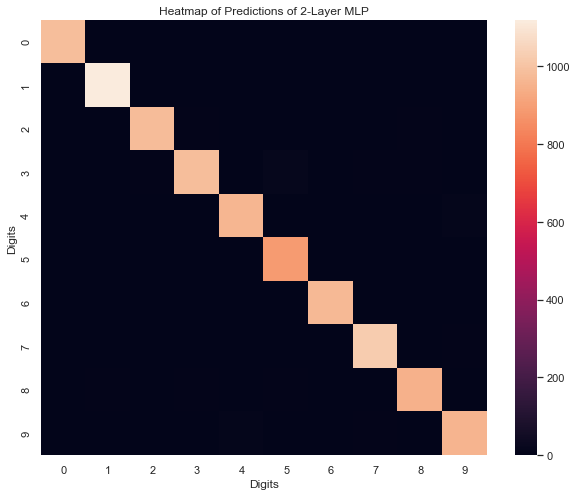

In [75]:
display_classification_results(y_test, y_pred,"Heatmap of Predictions of 2-Layer MLP")

### 2.2.5: Summary

Summarize your findings:
 * Which hyper-parameters were important and how did they influence your results?
 > *The hyperparameters for MLP classifier that were important were the paramaters number of epochs, number of neurons, optimizer algorithm, non-linear activation, and dropout rate.*
 * What were other design choices you faced?
 > *The other choice was the number of layers, which we decided to keep at 1. Also, we left the learning rate to be the default rate of SGD(0.01) and Adam optimizers (0.001) in Keras. As these values gave good enough results, we decided not to change them.*
 * Any other interesting insights...
 > *We actually saw that having Adam optimizer drastically improved the performance of the network. At the same time, dropout rate with number of neurons equalling the input dimension of 784 actually gave the best performance.*<br>
 > *We also see that validation loss is actually increasing very slightly towards the end of the 30 epochs, whereas the validation accuracy is also fluctuating, but seems to have a slight positive trend. This could mean that if we applied a learning rate decay after some epochs, it might have helped in reaching a better local minima.*

# 2.3: Model [M3]: *ConvNet*

####  Short description : *We use a ConvNet to perform the multiclass classification task. We use maxpool and dropout, and a fully connected layer.*

### 2.3.1: Hyper-parameters

Define hyper-parameters for your method here

In [0]:
# Define the parameter space
epoch = np.arange(10,40,10)
batch_size = [200] #[150, 200, 250]
activation =  ["sigmoid","relu"]
optimizer_algo = ["sgd","adam"]
## learning_rate
# learning_rate =  [0.001] #[0.001, 0.01]
dropout_rate = [0.3, 0.4, 0.5]
filter_size =  [(3,3), (5, 5)]
no_filters = [32] # [16, 32, 48]


param_space = {"epochs":epochs,\
               "batch_size": batch_size,\
               "activation": activation,\
               "optimizer_algo": optimizer_algo,\
               "dropout": dropout_rate,\
               "filter_size": filter_size,\
               "no_filters": no_filters 
              }

### 2.2.2: Model

Define your model here (all hyper-parameters in 2.1.1)

In [0]:
def CNN_model(no_filters = 32, filter_size=(5,5), activation = 'relu', optimizer_algo = 'adam', dropout=0.0):
  # create model
    model = Sequential()
    # Convolution layer
    model.add(Conv2D(filters=no_filters, kernel_size=filter_size, input_shape=(1, 28, 28), activation= activation))
    # Pooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Drop out 
    model.add(Dropout(dropout))
    # Flattening into a single vector
    model.add(Flatten())
    # Fully connected layer
    model.add(Dense(128, activation=activation))
    # output layer
    model.add(Dense(n_classes, activation='softmax'))
    # Compile model|
    if(optimizer_algo == 'adam'):
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    elif(optimizer_algo == 'sgd'):
        model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

    return model

In [0]:
model = KerasClassifier(build_fn=CNN_model)
grid_search_result = sklearn.model_selection.GridSearchCV(estimator=model, param_grid=param_space, verbose=2, cv=2)


### 2.3.3: Fit Model

Define optimization procedure and fit your model to the data

In [49]:
grid_search_fit = grid_search_result.fit(X_train, y_train)

Fitting 2 folds for each of 72 candidates, totalling 144 fits
[CV] activation=sigmoid, batch_size=200, dropout=0.3, epochs=10, filter_size=(3, 3), no_filters=32, optimizer_algo=sgd 
Epoch 1/10
30000/30000 [==============================] - 2s 81us/step - loss: 2.3172 - acc: 0.1038
Epoch 2/10
30000/30000 [==============================] - 2s 58us/step - loss: 2.3049 - acc: 0.1109
Epoch 3/10
30000/30000 [==============================] - 2s 58us/step - loss: 2.3000 - acc: 0.1170
Epoch 4/10
30000/30000 [==============================] - 2s 57us/step - loss: 2.2922 - acc: 0.1289
Epoch 5/10
30000/30000 [==============================] - 2s 58us/step - loss: 2.2867 - acc: 0.1383
Epoch 6/10
30000/30000 [==============================] - 2s 56us/step - loss: 2.2776 - acc: 0.1510
Epoch 7/10
30000/30000 [==============================] - 2s 58us/step - loss: 2.2677 - acc: 0.1717
Epoch 8/10
30000/30000 [==============================] - 2s 57us/step - loss: 2.2567 - acc: 0.1865
Epoch 9/10
30000/3

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.2s remaining:    0.0s


Epoch 1/10
30000/30000 [==============================] - 2s 82us/step - loss: 2.3142 - acc: 0.1068
Epoch 2/10
30000/30000 [==============================] - 2s 57us/step - loss: 2.3076 - acc: 0.1105
Epoch 3/10
30000/30000 [==============================] - 2s 57us/step - loss: 2.3057 - acc: 0.1111
Epoch 4/10
30000/30000 [==============================] - 2s 56us/step - loss: 2.3004 - acc: 0.1185
Epoch 5/10
30000/30000 [==============================] - 2s 56us/step - loss: 2.2964 - acc: 0.1254
Epoch 6/10
30000/30000 [==============================] - 2s 57us/step - loss: 2.2905 - acc: 0.1311
Epoch 7/10
30000/30000 [==============================] - 2s 55us/step - loss: 2.2856 - acc: 0.1406
Epoch 8/10
30000/30000 [==============================] - 2s 56us/step - loss: 2.2761 - acc: 0.1557
Epoch 9/10
30000/30000 [==============================] - 2s 54us/step - loss: 2.2659 - acc: 0.1709
Epoch 10/10
30000/30000 [==============================] - 1s 22us/step
[CV]  activation=sigmoid, ba

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed: 132.5min finished


Epoch 1/30
60000/60000 [==============================] - 16s 265us/step - loss: 0.2690 - acc: 0.9227
Epoch 2/30
60000/60000 [==============================] - 5s 80us/step - loss: 0.0968 - acc: 0.9705
Epoch 3/30
60000/60000 [==============================] - 5s 86us/step - loss: 0.0721 - acc: 0.9772
Epoch 4/30
60000/60000 [==============================] - 5s 83us/step - loss: 0.0579 - acc: 0.9818
Epoch 5/30
60000/60000 [==============================] - 5s 81us/step - loss: 0.0467 - acc: 0.9850
Epoch 6/30
60000/60000 [==============================] - 5s 86us/step - loss: 0.0401 - acc: 0.9872
Epoch 7/30
60000/60000 [==============================] - 5s 80us/step - loss: 0.0358 - acc: 0.9888
Epoch 8/30
60000/60000 [==============================] - 5s 83us/step - loss: 0.0309 - acc: 0.9898
Epoch 9/30
60000/60000 [==============================] - 5s 83us/step - loss: 0.0286 - acc: 0.9905
Epoch 10/30
60000/60000 [==============================] - 5s 84us/step - loss: 0.0251 - acc: 0.99

In [56]:
# summarize results
print("Best Validation Accuracy Score from CV: %.2f%% using %s" % ((100*grid_search_fit.best_score_), grid_search_fit.best_params_))

Best Validation Accuracy Score from CV: 98.78% using {'activation': 'relu', 'batch_size': 200, 'dropout': 0.5, 'epochs': 30, 'filter_size': (5, 5), 'no_filters': 32, 'optimizer_algo': 'adam'}


In [57]:
# build the model
model = CNN_model(no_filters = grid_search_fit.best_params_["no_filters"],\
                  filter_size=grid_search_fit.best_params_["filter_size"],\
                  activation = grid_search_fit.best_params_["activation"],\
                  optimizer_algo = grid_search_fit.best_params_["optimizer_algo"],\
                  dropout=grid_search_fit.best_params_["dropout"])
# Fit the model 
fit_model_final = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=grid_search_fit.best_params_["epochs"], batch_size=200, verbose=1)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 20s 331us/step - loss: 0.2686 - acc: 0.9218 - val_loss: 0.0857 - val_acc: 0.9743
Epoch 2/30
60000/60000 [==============================] - 6s 104us/step - loss: 0.0910 - acc: 0.9721 - val_loss: 0.0555 - val_acc: 0.9820
Epoch 3/30
60000/60000 [==============================] - 6s 103us/step - loss: 0.0680 - acc: 0.9789 - val_loss: 0.0401 - val_acc: 0.9870
Epoch 4/30
60000/60000 [==============================] - 6s 101us/step - loss: 0.0554 - acc: 0.9821 - val_loss: 0.0365 - val_acc: 0.9880
Epoch 5/30
60000/60000 [==============================] - 6s 99us/step - loss: 0.0470 - acc: 0.9853 - val_loss: 0.0342 - val_acc: 0.9879
Epoch 6/30
60000/60000 [==============================] - 6s 101us/step - loss: 0.0404 - acc: 0.9872 - val_loss: 0.0324 - val_acc: 0.9891
Epoch 7/30
60000/60000 [==============================] - 6s 98us/step - loss: 0.0364 - acc: 0.9880 - val_loss: 0.0311 - v

### 2.3.4: Evaluation

Evaluate your model.

When possible, you should have:
  * Loss curves: Plot epoch (# passes over training data) and loss
  * Accuracy curves: Plot epoch and accuracy over val/test set
  * Final numbers: Report final accuracy numbers for your model

In [0]:
y_pred = model.predict(X_test)
y_pred_label = np.argmax(y_pred, axis=1)
y_test_label = np.argmax(y_test, axis=1)



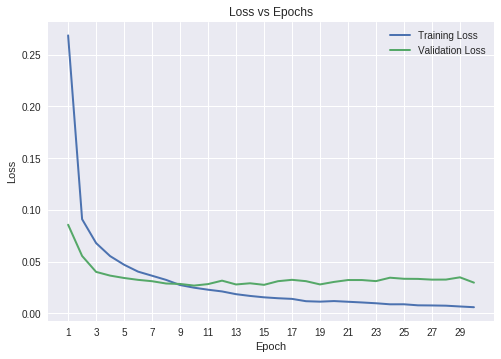

In [59]:
sns.set_context("notebook")
sns.set_style("darkgrid")

plt.plot(range(1,epochs[-1]+1),fit_model_final.history['loss'],label='Training Loss',linewidth=2.0)
plt.plot(range(1,epochs[-1]+1),fit_model_final.history['val_loss'],label='Validation Loss',linewidth=2.0)
plt.xticks(range(1,epochs[-1]+1,2));
plt.legend(loc='best')
plt.title('Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

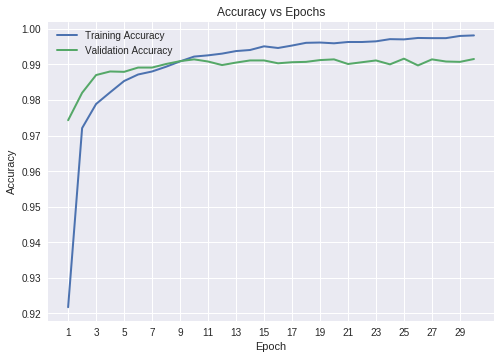

In [60]:
sns.set_context("notebook")
sns.set_style("darkgrid")

plt.plot(range(1,epochs[-1]+1),fit_model_final.history['acc'],label='Training Accuracy',linewidth=2.0)
plt.plot(range(1,epochs[-1]+1),fit_model_final.history['val_acc'],label='Validation Accuracy',linewidth=2.0)
plt.xticks(range(1,epochs[-1]+1,2));
plt.legend(loc='best')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

Test accuracy: 99.15%
Classification Report:
              precision    recall  f1-score   support

          0       0.99      1.00      0.99       980
          1       1.00      1.00      1.00      1135
          2       0.99      0.99      0.99      1032
          3       0.99      0.99      0.99      1010
          4       0.99      0.99      0.99       982
          5       0.99      0.99      0.99       892
          6       0.99      0.99      0.99       958
          7       0.99      0.99      0.99      1028
          8       0.99      0.99      0.99       974
          9       0.99      0.98      0.98      1009

avg / total       0.99      0.99      0.99     10000

Confidence Matrix:
 [[ 976    0    0    0    0    0    2    1    1    0]
 [   1 1131    1    0    0    0    2    0    0    0]
 [   0    0 1024    0    1    0    0    5    2    0]
 [   0    0    0 1004    0    4    0    0    1    1]
 [   0    0    0    0  976    0    1    0    0    5]
 [   1    0    0    6    0  88

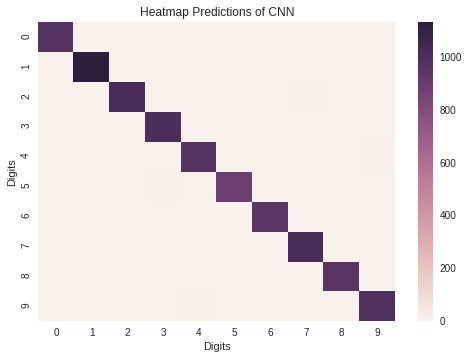

In [62]:
display_classification_results(y_test_label, y_pred_label,"Heatmap Predictions of CNN")

### 2.3.5: Summary

Summarize your findings:
 * Which hyper-parameters were important and how did they influence your results?
 > *The hyperparameters for CNN classifier that were important were the paramaters number of epochs, filter size, optimizer algorithm, non-linear activation, and dropout rate.*
 * What were other design choices you faced?
 > *The other choices include the fact that we used only one CNN layer with Maxpool and Dropout. We also set the number of filters to 32. The CNN layer is followed by a Fully Connected layer with 128 neurons.*
 * Any other interesting insights...
 > *We actually saw that having Adam optimizer again improved the performance of the network.*<br>
 > *We also see that validation loss is actually increasing very slightly towards the end of the 30 epochs, whereas the validation accuracy is also fluctuating, but seems to have a slight positive trend. This could mean that if we applied a learning rate decay after some epochs, it might have helped in reaching a better local minima.*

# 3. Summary

Enter your final summary here.

* You should now compare performance  on the three models [M1], [M2] and [M3]. Present this in a tabular format and/or using plots.


#### We plot the accuracies of the different models below.

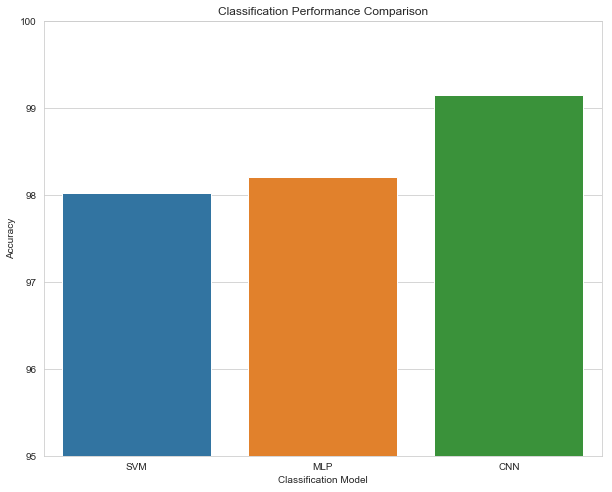

In [25]:
sns.set_style('whitegrid')
ax = sns.barplot(['SVM','MLP','CNN'],[98.02,98.21,99.15]);
ax.set(title="Classification Performance Comparison", xlabel="Classification Model", ylabel="Accuracy",ylim=(95,100));

*  Which model do you recommend to perform digit classification and why?

> According to the performance, as well as training time required, CNN provided the best balance. Not only did it give the highest accuracy (99.15%), but the training time required was less compared to the MLP. SVM also took a long time to train, and it also gave the lowest score. Hence, CNN would be our classifier of choice.

* Feel free to discuss other insightful observations.

> We realized that some learning rate decay mechanism might have helped the models even further. A more exhaustive hyperparamter search can also be performed to get even better hyperparameter set.